# Disaggregation of the Construction Sector in a Multiregional IOT

Data Inputs:
- Multiregional IOT including transaction matrix Z, final demand matrix Y
- Extension F of direct environmental pressures caused by each sector in the MRIOT and VA
- Total output shares, monetary
    - production value per subsector
- Total output per subsector, physical
    - building permits
    - permit_to_finaldemand_time
    - time series of stocks
    - lifetime per structure with stocks
- Material intensity per structure, physical
    - material content per structure
    - residual percentage (material not incorporated in structure)
    - onsite/inconstruction recycling percentage (material content not needed as extra supply)
- Material prices
- euro-to-usd
- Classifications
    - material-sector
    - structure-subsector

Data Output: 
- square Z with multiple construction subsectors
- long Y with multiple construction subsectors
- wide F with multiple construction subsectors

Further operations possible with the model outputs
- environmental multipliers per construction subsector
- total output x per construction subsector in physical/mixed and monetary units
- total inputs per construction subsector physical/mixed and monetary units

In [1]:
# Import modules
import pandas as pd
import numpy as np
import country_converter as coco
from sklearn.impute import KNNImputer

# Data processing functions
def icio_import(iot_year, cp_or_pyp):
    if cp_or_pyp == 'pyp':
        icio = pd.read_csv("data/ICIO_cp_pyp/ICIOpyp_"+str(iot_year)+"_fix.csv", index_col=[0], header=[0])
    else:
        icio = pd.read_csv("data/ICIO_cp_pyp/ICIOcp_"+str(iot_year)+".csv", index_col=[0], header=[0])
    icio.index = pd.MultiIndex.from_tuples(icio.index.str.split('_').tolist(), names=('region', 'sector'))
    icio.columns = pd.MultiIndex.from_tuples(icio.columns.str.split('_').tolist(), names=('region', 'sector'))
    for i in concord_sectors.index.tolist():
        icio.rename(columns={concord_sectors.iloc[i,1]:concord_sectors.iloc[i,0]}, inplace=True)
        icio.rename(index={concord_sectors.iloc[i,1]:concord_sectors.iloc[i,0]}, inplace=True)
    return icio

def multiply_subcategories(df_detail, df_aggregate):
    df_new = pd.DataFrame(index=df_detail.index, columns=df_detail.columns)
    for i in df_aggregate.index:
        df_new.update(df_detail.xs(i, axis=0, level=0, drop_level=False).mul(df_aggregate.loc[i], axis=1))
        
    return df_new

# Import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Visualisation functions
def lineplot_annotated(df):
    ax = df.plot(legend=False)

    for line, name in zip(ax.lines, df.columns):
        y = line.get_ydata()[-1]
        ax.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=10, va="center")

    plt.margins(0)
    plt.show()


# Display options
pd.options.display.float_format = '{:,.2f}'.format

#pd.reset_option('^display.', silent=True)

In [2]:
# SETTINGS

#Granularity of disaggregation
aggregated_output = False #if True, differentiates only between Buildings, Roads, Railway, Electricity, if False differentiates also single dwelling buildings, wind electricity etc.
if aggregated_output == True:
    agg = '_agg'
else:
    agg = ''

#Allocation of output across demanding sectors
if aggregated_output == True:
    zmatching = '' #if '_zmatching', the output of subsectors is matched to sectors demanding c, otherwise the output of subsectors is split evenly across sectors demanding c
else:
    zmatching = ''

#Size of transport stocks
transport_stocks = '_wiedenhoferscaled' #if '_wiedenhoferscaled', the transport stocks from Eurostat/Nguyen et al. are scaled to Wiedenhofer et al. 2024 levels, otherwise the transport stocks from Eurostat/Nguyen et al. are used

#Material intensity data
building_mi_source = '' # '_rasmi' for Fishman et al. 2024; '_carbenmats' for Röck et al. 2024 + Marinova et al. 2020 + Deetman et al. 2020
building_mi_range = 'p_50' #'p_50': median, 'p_25':lower bound, 'p_75':upper bound; only active for '_rasmi'

transport_mi_source = ''

#Prices
price_source = 'bonsai' #'bonsai' for Bonsai, 'comext' for EU Comext

#Allocation of residual inputs to construction
residuals_distribution = '_residualsinOCE' #if '_residualsdistributed', the residuals are distributed among the sectors with data for disaggregation and Other Civil Engineering has an average production recipe; if '_residualsinOCE' or '', the residuals are all in Other Civil Engineering


# KEY VARIABLES

#Regional classification
eu_labels = coco.CountryConverter().EU27as('ISO3').ISO3.to_list() #EU27 (as of 2020) countries in ISO3 format
central_europe = ['BEL', 'SVK', 'POL', 'AUT', 'NLD', 'HUN','IRL','DEU','CZE','SVN','LUX','GBR', 'CHE'] #EU countries + UK + Switzerland
southern_europe = ['ROU', 'PRT', 'BGR', 'CYP', 'ITA', 'HRV', 'FRA', 'ESP', 'GRC', 'MLT', 'MKD', 'SRB', 'ALB', 'BIH', 'MNE', 'TUR'] #EU countries + Albania, Bosnia and Herzegovina, North Macedonia, Montenegro, Serbia, Turkey
northern_europe = ['FIN', 'LTU', 'LVA','SWE','DNK','EST','NOR'] #EU countries + Norway
#source for all regions below: https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=10#regiondefs 
oecd_eu12_h = ['CZE', 'EST', 'HUN', 'POL', 'SVK', 'SVN', 'CYP', 'MLT'] #Cyprus, Czech Republic, Estonia, Hungary, Malta, Poland, Slovakia, Slovenia
oecd_eu12_m = ['BGR', 'LVA', 'LTU', 'ROU'] #Bulgaria, Latvia, Lithuania, Romania
oecd_eu15 = coco.CountryConverter().EU15as('ISO3').ISO3.to_list()
oecd_efta = ['ISL', 'NOR', 'CHE', 'LIE'] #Iceland, Norway, Switzerland, Liechtenstein
oecd_eeu = ['ALB', 'BIH', 'HRV', 'MNE', 'MKD', 'SRB'] #Albania, Bosnia and Herzegovina, Croatia, Montenegro, Serbia, The former Yugoslav Republic of Macedonia
oecd_tur = 'TUR' #Turkey
ref_eeu_fsu = ['BLR', 'MDA', 'UKR'] #Belarus, Republic of Moldova, Ukraine

#Population data, country-level
pop_all = pd.read_csv('data/population.txt', sep='\t', index_col=[0, 1, 2], header=0)
pop_all.index = pop_all.index.get_level_values(1)
pop_eu = pop_all.loc[eu_labels]

#Exchange rates
eur_to_usd = 1.18 #from euros to usd in 2018

#MRIOT-specific variables
concord_sectors = pd.read_excel('data/Concordance matrix ICIO.xlsx', sheet_name = 'Sectors', index_col=None, header=0, usecols=[0,1,2]) #concordance matrix with literal ICIO sector labels
iot_year = 2018 #target year of the disaggregation
c = 'Construction' #string of target sector
f_label = 'PROD_CO2' #string of target extension

m_labels = ['Basic metals', 
            'Fabricated metal products',
            'Mining and quarrying, non-energy producing products',
            'Other non-metallic mineral products', 
            'Rubber and plastic products',
            'Wood and products of wood and cork'] #list of materials/sectors with data for disaggregation of specified inputs
if building_mi_source == '_rasmi':
    m_labels.remove('Mining and quarrying, non-energy producing products')


n_labels = None #list of subsectors to be disaggregated

# Check and selection variables
r = 67 #number of countries
s = 45 #number of sectors in icio
if aggregated_output==True:
    n = 5
elif building_mi_source=='_rasmi':
    n = 15
else:
    n = 18 #number of subsectors to be disaggregated
m = len(m_labels) #number of materials/sectors with data for disaggregation #TODO: check that variable not assigned again throughout code
d = 6 #number of final demand categories

    

# Base MRIOT import
icio = icio_import(iot_year, 'cp') #importing in current prices ##############################################

Z = icio.iloc[0:r*s,0:r*s] #interindustry transaction matrix
Y = icio.iloc[0:r*s,r*s:-1] #final demand matrix
y = Y.sum(1) #final demand vector
x = icio.iloc[0:r*s,-1] #total output vector
x[x<1] = 0 #replace tiny values with 0 to avoid distortions when dividing by x

x_crow = x.xs(c, axis=0, level=1) #total output of c
Y_crow = Y.xs(c, axis=0, level=1) #final demand for c
Z_crow = Z.xs(c, axis=0, level=1) #intermediate demand for c
Z_ccol = Z.xs(c, axis=1, level=1) #production recipes of c

#Checks
print(len(x_crow)==r, len(Y_crow)==r, len(Z_crow)==r, len(Z_crow.columns)==r*s, len(Z_ccol)==r*s, len(Z_ccol.columns)==r)

#Export
x_crow.to_csv('processed_data/x_crow.csv')


# Extension import
F_sat = pd.read_csv('data/ICIO_cp_pyp/extension2018/OECDICIO_extensions_OECD_SINTEF_Gloria.csv', index_col=0, header=0) ##############################################
F_sat.index = pd.MultiIndex.from_tuples(F_sat.index.str.split('_').tolist(), names=('region', 'sector')) 
for i in concord_sectors.index.tolist():
        F_sat.rename(index={concord_sectors.iloc[i,1]:concord_sectors.iloc[i,0]}, inplace=True)
F_sat = F_sat.T
F_sat = F_sat[Z.columns]
F = F_sat

f = F/x.transpose() #extension intensity vector
f = f.replace([np.inf, -np.inf, np.nan], 0)

#Checks
print(f.loc[f_label].groupby(level=1).mean().idxmax())
print(agg)
print(building_mi_source)

True True True True True True
Electricity, gas, steam and air conditioning supply




## Preparation of total output model inputs

### Physical total output

In [305]:
# OPTIONS

bridges_tunnels = False #change to True to include a share of bridges and tunnels per road or rail type
# This option is relevant for national scale analysis of countries such as Austria, Italy and Slovakia which have relatively high shares (>5% of network length) of bridges and tunnels on some types of roads
# For EU-wide analysis of material use this option is not relevant due to the small overall share of bridges and tunnels

only_eu = True #change to False to include all countries available in each database in the analysis, if True uses only EU27 countries


# FUNCTIONS

def to_fd(df_slice, structure_label, fd_new):
    df_flat = df_slice
    df_flat.index = coco.convert(names=df_flat.index, to='ISO3')
    if only_eu == True:
        df_flat = df_flat[df_flat.index.isin(eu_labels)]
    df_flat = df_flat.unstack().reset_index()
    df_flat.columns = ['Year', 'Country', 'Value']
    df_flat = df_flat[df_flat['Value'].notna()]
    df_flat.Year = df_flat.Year.astype(str)
    df_flat['Structure'] = structure_label
    fd_new.Value = fd_new.Value.astype(float)
    fd_new = pd.merge(df_flat, fd_new, how='outer')
    
    return fd_new

def add_structure(fd, df, structure_labels, process, unit, source, scalar=1, lifetime=1):
    fd_new = pd.DataFrame(columns=fd.columns)

    for i in structure_labels:
        if process == 'expansion':
            df_flat = df[i].diff(axis=1).dropna(axis=1, how='all')
        elif process == 'replacement': #assumes constant linear replacement of existing stock and linear construction
            df_flat = df[i]/lifetime
        else:
            df_flat = df[i]
        df_flat.index = coco.convert(names=df_flat.index, to='ISO3')
        if only_eu == True:
            df_flat = df_flat[df_flat.index.isin(eu_labels)]
        df_flat = df_flat.unstack().reset_index()
        df_flat.columns = ['Year', 'Country', 'Value']
        df_flat = df_flat[df_flat['Value'].notna()]
        df_flat.Year = df_flat.Year.astype(str)
        df_flat['Structure'] = i
        fd_new = pd.merge(df_flat, fd_new, how='outer')
    
    fd_new['Value'] = fd_new['Value']*scalar
    fd_new['Value_source'] = source
    fd_new['Value_process'] = process
    fd_new['Unit'] = unit
    fd = pd.concat([fd, fd_new])

    return fd

def bso_extract(indicator):
    return bso.loc[bso['Indicator']==indicator].iloc[:,-3:].set_index(['Year','Country']).droplevel(0)

def fd_add_energy(fd, fd_energy, process):
    fd_energy.replace('Solar thermal', 'Solar photovoltaic', inplace=True)
    fd_energy.replace('Geothermal', 'Other renewables', inplace=True)
    fd_energy.replace('Tide, wave, ocean', 'Other renewables', inplace=True)
    fd_energy.replace('Other fuels n.e.c.', 'Combustible fuels', inplace=True)
    fd_energy = fd_energy.groupby(by=['Year', 'Country', 'Structure', 'Value_source', 'Value_process', 'Unit'], sort=False, as_index=False, dropna=False).sum()

    fd_energy['Value_source'] = 'Eurostat Electricity Production Capacity'
    fd_energy['Value_process'] = process
    fd_energy['Unit'] = 'MW'
    fd = pd.concat([fd, fd_energy])
    return fd


# INITIATE DATAFRAMES
fd = pd.DataFrame(columns=['Year', 'Country', 'Structure', 'Value', 'Value_source', 'Value_process','Unit'])

#### Buildings

In [306]:
#SHORT TERM BUSINESS STATISTICS: BUILDING PERMITS in Million m2
sts = {}
count = 38
for i in ['Buildings', 'Residential buildings', 'Residential buildings, except residences for communities', 'One-dwelling buildings', 'Two- and more dwelling buildings', 'Residences for communities', 'Non-residential buildings', 'Non-residential buildings, except office buildings', 'Office buildings']:
    sts[i] = pd.read_excel('external_data/240212_STS_BuildingPermits_sts_cobp_a_spreadsheet.xlsx', sheet_name='Sheet '+str(count), header=5, index_col=0, skiprows=5, skipfooter=7, na_values=[':', 'e', 'p', 's']) ##############################################
    sts[i].dropna(axis=1, how='all', inplace=True)
    sts[i].dropna(axis=0, how='all', inplace=True)
    count += 4

#converting format to final database
fd = add_structure(fd, sts, ['Buildings', 'Residential buildings', 'Non-residential buildings'], 'building permit', 'm2', 'EU Short-term Business Statistics Construction', 1000000)

#assuming same share of subgroups of buildings for all countries
sts_shares = pd.DataFrame(index=sts['Buildings'].columns)
for i,k in {'One-dwelling buildings':'Residential buildings', 'Two- and more dwelling buildings':'Residential buildings', 'Residences for communities':'Residential buildings', 'Non-residential buildings, except office buildings':'Non-residential buildings','Office buildings':'Non-residential buildings'}.items():
    fd = to_fd(sts[k], i, fd)
    sts_shares[i] = sts[i].iloc[0]/sts[k].iloc[0]
    for year in range(int(fd.Year.min()), int(fd.Year.max())+1, 1):
        fd.loc[(fd['Structure']==i) & (fd['Year']==str(year)),'Value'] = (fd.loc[(fd['Structure']==k) & (fd['Year']==str(year)),'Value']*sts_shares.loc[str(year),i]).to_list()

fd['Value_source'] = 'EU Short-term Business Statistics Construction'
fd['Value_process'] = 'building permit'
fd['Unit'] = 'm2'

#simulating delay between permit and material use for construction TODO: use the three thirds approach
delay_permit_to_construction = round(2.6,0) #average delay between issue of permit and finalisation of construction, based on Röck ##############################################
fd.Year = [str(int(int(i)+delay_permit_to_construction)) for i in fd.Year]

#IMPORT BUILDING STOCK OBSERVATORY
bso = pd.read_excel('external_data/240127_BSO_BuildingStock_EU_2016-2020.xlsx', sheet_name='data', header=0) ##############################################
bso = bso[bso['Year']==2016]
bso.Country = coco.CountryConverter().pandas_convert(series=bso.Country, to='ISO3')

#assuming the share of subtypes of non-residential buildings in BSO in 2016 also applies to construction in STS
fd_bso = pd.DataFrame(columns=fd.columns) 
bso_shares = pd.DataFrame(index=bso_extract('Non-residential floor area').index)
indicators = ['Floor area of other buildings', 'Floor area of education buildings', 'Floor area of health buildings', 'Floor area of hotel and restaurant buildings', 'Floor area of wholesale and retail trade buildings']
for i in indicators:
    fd_bso = fd.loc[fd['Structure']=='Non-residential buildings, except office buildings']
    fd_bso['Structure'] = i
    bso_shares[i] = bso_extract(i) / (bso_extract('Non-residential floor area') - bso_extract('Floor area of office buildings'))
    for country in fd_bso.Country.unique():
        fd_bso.loc[fd_bso['Country']==country,'Value'] = (fd_bso.loc[fd_bso['Country']==country,'Value']*bso_shares.loc[country,i]).to_list()   
    fd_bso['Value_source'] = 'EU Building Stock Observatory, scaled by EU Short-term Business Statistics'
    fd_bso['Value_process'] = 'building permit'
    fd_bso['Unit'] = 'm2'
    fd = pd.concat([fd, fd_bso])

    # #BUILDING STOCK OBSERVATORY updated version with 2020 data (exactly same shares as hotmaps 2016 data)
    # bso = pd.read_excel('external_data/240426_BSO_BuildingStockFlows_EU_1990-2020_data0.xlsx', sheet_name='Export', header=0) ##############################################
    # bso = bso[(bso['Subject']=='Useful floor area')&(bso['Country']!='EU27')&(bso['Building occupancy'].notna())]
    # bso.Country = coco.CountryConverter().pandas_convert(series=bso.Country, to='ISO3')

    # #assuming the share of subtypes of non-residential buildings in BSO in 2016 also applies to construction in STS
    # fd_bso = pd.DataFrame(columns=fd.columns) 
    # bso_shares = pd.DataFrame(index=bso[bso['Building use']=='Apartment buildings'].loc[:,['Country','Value']].groupby(by='Country').sum().index)
    # indicators = ['Other non-residential buildings', 'Educational buildings', 'Health buildings', 'Hotels and Restaurants', 'Trade buildings']
    # for i in indicators:
    #     fd_bso = fd.loc[fd['Structure']=='Non-residential buildings, except office buildings']
    #     fd_bso['Structure'] = i
    #     bso_shares[i] = bso[bso['Building use']==i].loc[:,['Country','Value']].groupby(by='Country').sum() / (bso[bso['Sector']=='Service'].loc[:,['Country','Value']].groupby(by='Country').sum() - bso[bso['Building use']=='Offices'].loc[:,['Country','Value']].groupby(by='Country').sum())
    #     for country in fd_bso.Country.unique():
    #         fd_bso.loc[fd_bso['Country']==country,'Value'] = (fd_bso.loc[fd_bso['Country']==country,'Value']*bso_shares.loc[country,i]).to_list()   
    #     fd_bso['Value_source'] = 'EU Building Stock Observatory, scaled by EU Short-term Business Statistics'
    #     fd_bso['Value_process'] = 'building permit'
    #     fd_bso['Unit'] = 'm2'
    #     fd = pd.concat([fd, fd_bso])
    
#assuming 10% of all building permits are for maintenance not construction
share_maintenance_in_permits = 0.1 #share of permits issued for maintenance of all building permits issues, based on Destatis ##############################################
fd_maintain = fd.copy()
fd_maintain.Value = fd.Value * share_maintenance_in_permits
fd_maintain['Value_process'] = 'replacement' #maintenance is considered as replacement of existing buildings

fd.Value = fd.Value * (1-share_maintenance_in_permits)
fd['Value_process'] = 'expansion' #construction is considered as expansion of existing building stock

#conversion to final database
fd = pd.concat([fd, fd_maintain])


# LUCAS Land Cover and Land Use Statistics: Greenhouses
lucas = {}
lucas['Greenhouses'] = pd.read_excel('external_data/240214_LUCAS_LandCover_Greenhouses_lan_lcv_art__custom_9878113_spreadsheet.xlsx', sheet_name='Sheet 12', header=1, index_col=0, skiprows=7, skipfooter=7, na_values=[':', 'bu', 'b','u']) ##############################################
lucas['Greenhouses'].dropna(axis=1, how='all', inplace=True)
lucas['Greenhouses'].dropna(axis=0, how='all', inplace=True)
lucas_cols = pd.DataFrame(columns=[str(i) for i in range(int(lucas['Greenhouses'].columns.min()), int(lucas['Greenhouses'].columns.max())+1, 1)])
lucas['Greenhouses'] = pd.merge(lucas['Greenhouses'], lucas_cols, how='outer').reindex(lucas_cols.columns, axis=1).set_index(lucas['Greenhouses'].index).astype(float)
lucas['Greenhouses'] = lucas['Greenhouses'].interpolate(method='linear', limit_direction='both', axis=1)

#conversion to final database
lifetime_greenhouse = 25 #years, lifetime of a greenhouse, based on ecoinvent ##############################################
fd = add_structure(fd, lucas, ['Greenhouses'], 'replacement', 'm2', 'EU LUCAS interpolated', 1000000, lifetime_greenhouse)
fd = add_structure(fd, lucas, ['Greenhouses'], 'expansion', 'm2', 'EU LUCAS interpolated', 1000000) #construction of new greenhouses

European Union - 27 countries (from 2020) not found in regex
Euro area – 20 countries (from 2023) not found in regex
Euro area - 19 countries  (2015-2022) not found in regex
European Union - 27 countries (from 2020) not found in regex
Euro area – 20 countries (from 2023) not found in regex
Euro area - 19 countries  (2015-2022) not found in regex
European Union - 27 countries (from 2020) not found in regex
Euro area – 20 countries (from 2023) not found in regex
Euro area - 19 countries  (2015-2022) not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
/var/folders/__/twfrdq8n75n5f0118_f88270000

#### Transport

In [307]:
#TODO: add delay in infrastructure construction, e.g. two years before road network is expanded, construction starts --> materials get consumed

# WIEDENHOFER ET AL. 2024: ROAD LENGTHS used to impute values for missing data in Nguyen et al. 2023 and Eurostat
wiedenhofer = pd.read_excel('external_data/240212_Wiedenhofer_2024_MobilityInfrastructure_2021 - full supplementary data.xlsx', sheet_name='Lengths', header=0, index_col=0, skiprows=3) ##############################################
wiedenhofer.drop('Income level', axis=1, inplace=True)
wiedenhofer = wiedenhofer.loc[eu_labels]

wiedenhofer_sum = pd.DataFrame(index=wiedenhofer.index)
for i in range(0, 21, 3):
    wiedenhofer_sum[wiedenhofer.iloc[:,i].name] = wiedenhofer.iloc[:,i:i+3].sum(1)
state_roads_labels = ['Primary', 'Secondary', 'Tertiary']
wiedenhofer_sum['State roads'] = wiedenhofer[state_roads_labels].sum(1)

#widths of transport infrastructure
wiedenhofer_mi = pd.read_excel('external_data/240212_Wiedenhofer_2024_MobilityInfrastructure_2021 - full supplementary data.xlsx', sheet_name='MI', index_col=[0,1], header=[0,1], skiprows=3, skipfooter=4, na_values='                        -  ') ##############################################
wiedenhofer_mi = wiedenhofer_mi.droplevel(0, axis=0)
wiedenhofer_mi.fillna(0, inplace=True)
wiedenhofer_mi = wiedenhofer_mi.astype(float)
widths = wiedenhofer_mi.xs('Width', axis=1, level=1)

widths_ = widths.loc[widths.index.isin(wiedenhofer_sum.columns)].T
widths_.index = coco.CountryConverter().convert(widths_.index, to='ISO3')
widths_['State roads'] = widths_[state_roads_labels].mean(1)

# NGUYEN ET AL. 2023: ROAD LENGTHS
nguyen = {} #km
labels = ['Motorways', 'State roads', 'Provincial roads', 'Communal roads']
for i in labels:
    nguyen[i] = pd.read_excel('external_data/240214_Nguyen2023_Roads_Eurostat_transcribed.xlsx', sheet_name=i, header=0, index_col=0, dtype=object) ##############################################
    nguyen[i] = nguyen[i].astype(np.float64)
    nguyen[i].index=coco.convert(names=nguyen[i].index, to='ISO3')
    nguyen[i].replace(0, np.nan, inplace=True)


wiedenhofer_nguyen_map = {'Motorway': 'Motorways', 'State roads':'State roads', 'Rural':'Provincial roads', 'Local':'Communal roads'}
nguyen_area = {} #km2
for k,i in wiedenhofer_nguyen_map.items():
    df = nguyen[i].reindex(eu_labels).assign(wiedenhofer=wiedenhofer_sum[k].values)
    df.columns = df.columns.astype(str)
    nguyen[i] = pd.DataFrame(KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')\
            .fit(df).transform(df), index=df.index, columns=df.columns)
    nguyen[i].drop('wiedenhofer', axis=1, inplace=True)
    if transport_stocks == '_wiedenhoferscaled':
        nguyen[i] = nguyen[i] / nguyen[i].div(wiedenhofer_sum[k], axis=0)
    nguyen_area[i] = nguyen[i] * widths_.loc['AUT', k]/1e3 #km2

# Option with bridges and tunnels based on Wiedenhofer et al. 2024
if bridges_tunnels == True:
    wiedenhofer_bridges = pd.DataFrame(index=wiedenhofer.index)
    for i in range(0, 21, 3):
        wiedenhofer_bridges[wiedenhofer.iloc[:,i].name] = wiedenhofer.iloc[:,i+1]/wiedenhofer.iloc[:,i:i+3].sum(1)
    wiedenhofer_bridges['State roads'] = wiedenhofer[[i+' bridge' for i in state_roads_labels]].sum(1)/wiedenhofer_sum['State roads']

    wiedenhofer_tunnels = pd.DataFrame(index=wiedenhofer.index)
    for i in range(0, 21, 3):
        wiedenhofer_tunnels[wiedenhofer.iloc[:,i].name] = wiedenhofer.iloc[:,i+2]/wiedenhofer.iloc[:,i:i+3].sum(1)
    wiedenhofer_tunnels['State roads'] = wiedenhofer[[i+' tunnel' for i in state_roads_labels]].sum(1)/wiedenhofer_sum['State roads']

    for w_lab, n_lab in wiedenhofer_nguyen_map.items():
        nguyen[n_lab+' bridges'] = nguyen[n_lab].mul(wiedenhofer_bridges[w_lab].fillna(0), axis=0).fillna(0)
        nguyen[n_lab+' tunnels'] = nguyen[n_lab].mul(wiedenhofer_tunnels[w_lab].fillna(0), axis=0).fillna(0)
        nguyen[n_lab] = nguyen[n_lab] - nguyen[n_lab+' bridges'] - nguyen[n_lab+' tunnels']
        labels.append(n_lab+' bridges')
        labels.append(n_lab+' tunnels')

#conversion to final database
fd = add_structure(fd, nguyen, labels, 'stock', 'km', 'Eurostat / Nguyen et al. 2023, missing countries imputed with Wiedenhofer et al. 2024') #for Transport Infrastructure only stock is recorded, since maintenance depending on lifetime is calculated in material section
fd = add_structure(fd, nguyen, labels, 'expansion', 'km', 'Eurostat / Nguyen et al. 2023, missing countries imputed with Wiedenhofer et al. 2024')
fd = add_structure(fd, nguyen_area, labels, 'stock-area', 'km2', 'Eurostat / Nguyen et al. 2023, widths according to and missing countries imputed with Wiedenhofer et al. 2024' )

#EUROSTAT: RAILWAY LENGTHS
eurostat = {}
eurostat['Railway'] = pd.read_excel('external_data/240214_EUROSTAT_RailwayTrackLength_rail_if_tracks_spreadsheet.xlsx', sheet_name='Sheet 1', header=1, index_col=0, skiprows=7, skipfooter=7, na_values=[':', 'b', 'p', 's', 'z']) ##############################################
eurostat['Railway'].dropna(axis=1, how='all', inplace=True)
eurostat['Railway'].dropna(axis=0, how='all', inplace=True)
eurostat['Railway'].index = coco.convert(names=eurostat['Railway'].index, to='ISO3')
eurostat['Railway'] = eurostat['Railway'].interpolate(method='linear', limit_direction='both', axis=1)

df = eurostat['Railway'].reindex(eu_labels).assign(wiedenhofer=wiedenhofer_sum['Railway'].values)
df.columns = df.columns.astype(str)
eurostat['Railway'] = pd.DataFrame(KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')\
            .fit(df).transform(df), index=df.index, columns=df.columns)
eurostat['Railway'].drop('wiedenhofer', axis=1, inplace=True)
eurostat_area = {} #km2
eurostat_area['Railway'] = eurostat['Railway'] * widths_.loc['AUT', 'Railway']/1e3 #km2

labels = ['Railway']

# Option with bridges and tunnels based on Wiedenhofer et al. 2024
if bridges_tunnels == True:
    eurostat['Railway bridges'] = eurostat['Railway'].mul(wiedenhofer_bridges['Railway'].fillna(0), axis=0).fillna(0)
    eurostat['Railway tunnels'] = eurostat['Railway'].mul(wiedenhofer_tunnels['Railway'].fillna(0), axis=0).fillna(0)
    eurostat['Railway'] = eurostat['Railway'] - eurostat['Railway bridges'] - eurostat['Railway tunnels']
    labels.append('Railway bridges')
    labels.append('Railway tunnels')

#conversion to final database
fd = add_structure(fd, eurostat, labels, 'stock', 'km', 'Eurostat Railway Transport Infrastructure, interpolated') #for Transport Infrastructure only stock is recorded, since maintenance depending on lifetime is calculated in material section
fd = add_structure(fd, eurostat, labels, 'expansion', 'km', 'Eurostat Railway Transport Infrastructure, interpolated')  
fd = add_structure(fd, eurostat_area, labels, 'stock-area', 'km2', 'Eurostat Railway Transport Infrastructure, widths according to and missing countries imputed with Wiedenhofer et al. 2024' )


GCC not found in ISO3
Global average * not found in regex


#### Electricity Production Capacity

In [308]:
#EUROSTAT: ELECTRICITY PRODUCTION CAPACITY (MW)

#TODO: add delay in infrastructure construction, e.g. five years before plant is operational, construction starts --> materials get consumed
sheet_lifetime_map = [(1, 'Total Electricity Production Capacity', np.NaN), #list with triples indicating sheet, technology, lifetime of power plant (lifetime based on based on Van Vuuren et al. 2006 in Deetman et al. 2021) ##############################################
     (7, 'Combustible fuels', 40), 
     (13, 'Hydro', 80), 
     (37, 'Geothermal', 30), 
     (43, 'Wind', 25), 
     (61, 'Solar thermal',25), 
     (67, 'Solar photovoltaic', 25), 
     (85, 'Tide, wave, ocean', 30), 
     (91, 'Nuclear and other fuels n.e.c.', 60),
     (97, 'Other fuels n.e.c.', 40)] #assuming other fuels has same lifetime as combustible fuels 
fd_eurostat = pd.DataFrame(columns=fd.columns)
fd_expansion = pd.DataFrame(columns=fd.columns)
eurostat_auto = {}
for (key, energy, lifetime) in sheet_lifetime_map:
    eurostat[energy] = pd.read_excel('external_data/240214_EUROSTAT_ElectricityProductionCapacity_nrg_inf_epc_spreadsheet.xlsx', sheet_name='Sheet '+str(key), header=0, index_col=0, engine='openpyxl', skiprows=10, skipfooter=3, na_values=[':']) ##############################################
    eurostat[energy].dropna(axis=1, how='all', inplace=True)
    eurostat[energy].dropna(axis=0, how='all', inplace=True)
    eurostat[energy] = eurostat[energy].interpolate(method='linear', limit_direction='forward', axis=1)

    eurostat_auto[energy] = pd.read_excel('external_data/240214_EUROSTAT_ElectricityProductionCapacity_nrg_inf_epc_spreadsheet.xlsx', sheet_name='Sheet '+str(key+1), header=0, index_col=0, engine='openpyxl', skiprows=10, skipfooter=3, na_values=[':']) ##############################################
    eurostat_auto[energy].dropna(axis=1, how='all', inplace=True)
    eurostat_auto[energy].dropna(axis=0, how='all', inplace=True)
    eurostat_auto[energy] = eurostat_auto[energy].interpolate(method='linear', limit_direction='forward', axis=1)

    eurostat[energy] = eurostat[energy] + eurostat_auto[energy]
    fd_eurostat = to_fd(eurostat[energy].iloc[2:]/lifetime, energy, fd_eurostat)
    fd_expansion = to_fd(eurostat[energy].iloc[2:].diff(axis=1), energy, fd_expansion)

#conversion to final database
fd = fd_add_energy(fd, fd_eurostat, 'replacement')
fd = fd_add_energy(fd, fd_expansion, 'expansion')

#### Checks and Export

In [309]:
#renaming to common structure labels
replacement_map = {'Residences for communities':'Buildings, dwelling multi',
                    'One-dwelling buildings':'Buildings, dwelling single',
                    'Two- and more dwelling buildings':'Buildings, dwelling multi',
                    'Office buildings': 'Buildings, offices',
                    'Floor area of education buildings':'Buildings, education',
                    'Floor area of wholesale and retail trade buildings': 'Buildings, wholesale and retail',
                    'Greenhouses':'Buildings, greenhouses',
                    'Floor area of other buildings':'Buildings, other',
                    'Floor area of health buildings':'Buildings, other',
                    'Floor area of hotel and restaurant buildings': 'Buildings, other', 
                    'Communal roads':'Roads, communal',
                    'Provincial roads':'Roads, provincial',
                    'State roads':'Roads, state',
                    'Motorways':'Roads, motorway',
                    'Railway':'Railways', 
                    'Nuclear and other fuels n.e.c.': 'Electricity, nuclear and other fuels',
                    'Other renewables':'Electricity, other renewables',
                    'Solar photovoltaic':'Electricity, solar photovoltaic',
                    'Wind':'Electricity, wind',
                    'Hydro':'Electricity, hydro',
                    'Combustible fuels':'Electricity, combustible fuels'}

fd['Structure'] = fd['Structure'].replace(replacement_map, regex=True)

#EXPORT
fd_out = fd.groupby(['Unit', 'Value_source', 'Structure', 'Value_process', 'Country', 'Year']).sum(numeric_only=True)
fd_out.to_csv('processed_data/x_crow_sub_phys_long'+transport_stocks+'.csv')

fd_out = fd_out.drop(['Non-residential buildings, except office buildings', 'Non-residential buildings', 'Residential buildings', 'Buildings', 'Total Electricity Production Capacity'], axis=0, level=2)
fd_out = fd_out.drop('km2', axis=0, level=0)
fd_out.to_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv')

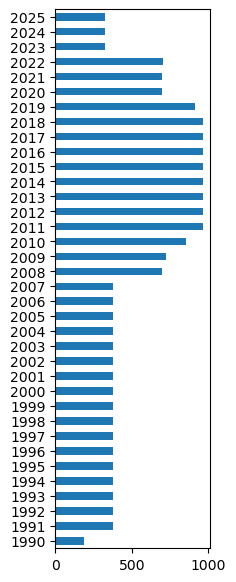

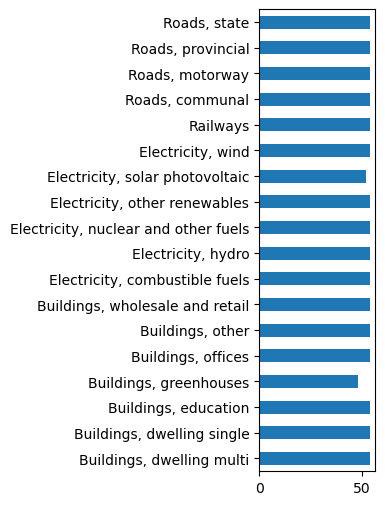

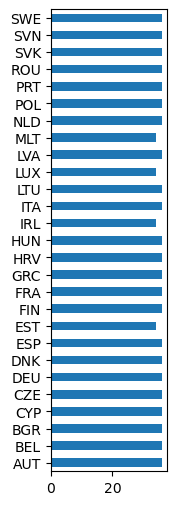

In [310]:
#VISUAL CHECKS of available data
df = fd_out.reset_index().drop('Value', axis=1)
df.Year.value_counts().sort_index().plot(kind='barh', figsize=(2,7))
plt.savefig('images/bars_x_crow_sub_phys_datapoints_per_year.png')
plt.show()
df[df['Year']==str(iot_year)].Structure.value_counts().sort_index().plot(kind='barh', figsize=(1.5,6))
plt.show()
df[df['Year']==str(iot_year)].Country.value_counts().sort_index().plot(kind='barh', figsize=(1.5,6))
plt.show()

In [311]:
#PLOTS of construction volumes

#construction volume (incl. expansion and maintenance work) of buildings
fd_out = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv', index_col=[0,1,2,3,4,5], header=0)
fd_out[fd_out<0] =0

m_plot = (fd_out.loc[('m2', slice(None), slice(None), slice(None), slice(None), slice(None))].groupby(['Year', 'Structure']).sum().drop('Buildings, greenhouses', axis=0, level=1).sort_index(level=[0,1], ascending=False)/1e6).reset_index()
m_plot = m_plot[(m_plot['Year']<2020) & (m_plot['Year']>2010)]
fig = px.area(m_plot, x='Year', y='Value', color='Structure',labels={'Value':'construction volume [km<sup>2</sup>]'}, template='simple_white', 
             color_discrete_sequence=px.colors.sequential.YlOrBr_r)
fig.update_layout(width=600, height=350, legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedarea_x_crow_sub_phys_buildings_eu.svg')
fig.show()

#construction volume (incl. expansion and maintenance work) of electricity infrastructure
m_plot = (fd_out.loc[('MW', slice(None), slice(None), slice(None), slice(None), slice(None))].groupby(['Year', 'Structure']).sum().sort_index(level=[0,1], ascending=False)/1e3).reset_index()
m_plot = m_plot[(m_plot['Year']<2020) & (m_plot['Year']>2010)]
fig = px.area(m_plot, x='Year', y='Value', color='Structure',labels={'Value':'construction volume [1000 MW]'}, template='simple_white', 
             color_discrete_sequence=px.colors.sequential.Turbo_r[6:])
fig.update_layout(width=600, height=350, legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedarea_x_crow_sub_phys_electricity_eu.svg')
fig.show()

fd_out = pd.read_csv('processed_data/x_crow_sub_phys_long'+transport_stocks+'.csv', index_col=[0,1,2,3,4,5], header=0)
fd_out[fd_out<0] =0
#stocks of transport infrastructure
m_plot = (fd_out.loc[('km2', slice(None), slice(None), 'stock-area', slice(None), slice(None))].groupby(['Year', 'Structure']).sum().sort_index(level=[0,1], ascending=False)/1e3).reset_index()
m_plot = m_plot[(m_plot['Year']<2020) & (m_plot['Year']>2010)].sort_values(by=['Year','Value','Structure'])
fig = px.area(m_plot, x='Year', y='Value', color='Structure',labels={'Value':'stocks [1000 km<sup>2</sup>]'}, template='simple_white', 
             color_discrete_sequence=px.colors.sequential.Turbo)
fig.update_layout(width=600, height=350, legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedarea_x_crow_sub_phys_transport_eu.svg')
fig.show()

### Monetary total output

#### Data collection and cleaning

In [312]:
#STRUCTURAL BUSINESS STATISTICS: PRODUCTION VALUE per subsector in Million €
sbs_map = {1:'Construction',
     7:'Construction of buildings',
     37:'Civil engineering',
     43:'Construction of roads and railways',
     49:'Construction of roads and motorways', #misses values for NLD, CZE, MLT
     55:'Construction of railways and underground railways', #misses values for NLD, CZE, LUX
     61:'Construction of bridges and tunnels', #misses values for CZE, MLT
     67:'Construction of utility projects',
     79:'Construction of utility projects for electricity and telecommunications', #misses values for NLD, CZE, LUX, BEL
     103:'Specialised construction activities', 
     157:'Building completion and finishing'}

eurostat = {}

for key, sector in sbs_map.items():
    eurostat[sector] = pd.read_excel('external_data/240212_StructuralBusinessStatistics_TotalOutput_Labour_sbs_na_con_r2__custom_9831151_spreadsheet.xlsx', sheet_name='Sheet '+str(key), header=0, index_col=0, engine='openpyxl', skiprows=8, skipfooter=9, na_values=[':','de', 'b', 'p','d', 'e', 's', 'c', 'bd', 'du','u','bu', 'bu']) ##############################################
    eurostat[sector] = eurostat[sector].select_dtypes(include=['float64'])
    eurostat[sector].dropna(axis=1, how='all', inplace=True)
    eurostat[sector].dropna(axis=0, how='all', inplace=True)
    eurostat[sector].index = coco.convert(names=eurostat[sector].index, to='ISO3')
    eurostat[sector] = eurostat[sector].drop('not found', axis=0).reindex(eu_labels)
    eurostat[sector] = eurostat[sector].astype(np.float64)
    eurostat[sector] = eurostat[sector].interpolate(method='linear', limit_direction='both', axis=1)

#imputing missing values based on higher level values
sbs_detail_map = {'Construction of roads and motorways': 'Construction of roads and railways', 
     'Construction of railways and underground railways': 'Construction of roads and railways',
     'Construction of bridges and tunnels': 'Construction of roads and railways',
     'Construction of utility projects for electricity and telecommunications': 'Construction of utility projects'}
for k,i in sbs_detail_map.items():
    for year in range(int(eurostat[k].columns.min()), int(eurostat[k].columns.max())+1, 1):
        df = pd.concat([eurostat[k][str(year)], eurostat[i][str(year)]], axis=1)
        eurostat[k][str(year)] = KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')\
                    .fit(df).transform(df)[:,0]

#calculating horizontal differentiation of construction (instead of vertical)
eurostat['Other specialised construction activities'] = eurostat['Specialised construction activities'].sub(eurostat['Building completion and finishing'],fill_value=0)
eurostat['Construction except other specialised construction activities'] = eurostat['Construction'].sub(eurostat['Other specialised construction activities'],fill_value=0)

eurostat['Buildings'] = eurostat['Construction of buildings'].add(eurostat['Building completion and finishing'], fill_value=0)
eurostat['Buildings'] = eurostat['Buildings'].add((eurostat['Buildings'].div(eurostat['Construction except other specialised construction activities'], fill_value=0)).mul(eurostat['Other specialised construction activities'],fill_value=0), fill_value=0)

eurostat['Roads'] = eurostat['Construction of roads and motorways'].add((eurostat['Construction of roads and motorways'].div(eurostat['Construction of roads and motorways'].add(eurostat['Construction of railways and underground railways'],fill_value=0), fill_value=0)).mul(eurostat['Construction of bridges and tunnels'], fill_value=0), fill_value=0)
eurostat['Roads'] = eurostat['Roads'].add((eurostat['Roads'].div(eurostat['Construction except other specialised construction activities'],fill_value=0)).mul(eurostat['Other specialised construction activities'], fill_value=0), fill_value=0)

eurostat['Railways'] = eurostat['Construction of railways and underground railways'].add((eurostat['Construction of railways and underground railways'].div(eurostat['Construction of roads and motorways'].add(eurostat['Construction of railways and underground railways'], fill_value=0), fill_value=0)).mul(eurostat['Construction of bridges and tunnels'], fill_value=0), fill_value=0)
eurostat['Railways'] = eurostat['Railways'].add((eurostat['Railways'].div(eurostat['Construction except other specialised construction activities'], fill_value=0)).mul(eurostat['Other specialised construction activities'], fill_value=0), fill_value=0)

eurostat['Electricity'] = eurostat['Construction of utility projects for electricity and telecommunications'].add((eurostat['Construction of utility projects for electricity and telecommunications'].div(eurostat['Construction except other specialised construction activities'],fill_value=0)).mul(eurostat['Other specialised construction activities'],fill_value=0), fill_value=0)

eurostat['Other civil engineering'] = eurostat['Construction'].sub(eurostat['Buildings'],fill_value=0).sub(eurostat['Roads'],fill_value=0).sub(eurostat['Railways'],fill_value=0).sub(eurostat['Electricity'],fill_value=0) #residual total output not allocated to other subsectors

fd = add_structure(fd, eurostat, eurostat.keys(), 'production value', '€', 'Structural Business Statistics', 1e6)

European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 coun

#### Further detailing of buildings, road, electricity subsectors

In [313]:
if aggregated_output == True: 
    y_c_sub_pc = {}
    y_c_sub = {}
    for k in ['Buildings', 'Roads', 'Railways', 'Electricity', 'Other civil engineering']:
        y_c_sub_pc[k] = eurostat[k]/eurostat['Construction']
        y_c_sub[k] = eurostat[k]
else:
    # reflect whether price should refer to expansion, replacement or stocks!
    p_c_buildings = fd[(fd['Structure']=='Buildings')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') / fd[(fd['Structure']=='Buildings')&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum().unstack(1).droplevel(0, axis=1) # €/m2
    p_c_buildings.replace(0, np.NaN, inplace=True)
    p_c_buildings.dropna(axis=1, how='all', inplace=True)

    p_c_roads = fd[(fd['Structure']=='Roads')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') /fd[(fd['Structure'].isin(['Roads, communal', 'Roads, provincial','Roads, state','Roads, motorway']))&(fd['Value_process'].isin(['stock']))].groupby(by=['Country', 'Year'],sort=False).sum().unstack(1).droplevel(0, axis=1) # €/km
    p_c_roads.replace(0, np.NaN, inplace=True)
    p_c_roads.dropna(axis=1, how='all', inplace=True)
    for i in p_c_roads.columns[p_c_roads.isnull().any(axis=0)]:
            p_c_roads[i].fillna(p_c_roads[i].median(),inplace=True)

    p_c_railways = fd[(fd['Structure']=='Railways')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') /fd[(fd['Structure'].isin(['Railways']))&(fd['Value_process'].isin(['stock']))].groupby(by=['Country', 'Year'],sort=False).sum().unstack(1).droplevel(0, axis=1) # €/km
    p_c_railways.replace(0, np.NaN, inplace=True)
    p_c_railways.dropna(axis=1, how='all', inplace=True)
    for i in p_c_railways.columns[p_c_railways.isnull().any(axis=0)]:
            p_c_railways[i].fillna(p_c_railways[i].median(),inplace=True)

    #check difference with total electricity
    p_c_electricity = fd[(fd['Structure']=='Electricity')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') / fd[(fd['Structure'].isin(['Electricity, combustible fuels','Electricity, nuclear and other fuels','Electricity, other renewables', 'Electricity, solar photovoltaic','Electricity, wind', 'Electricity, hydro']))&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).agg(lambda x: x[x>0].sum()).unstack(1).droplevel(0, axis=1) # €/MW
    p_c_electricity.replace(0, np.NaN, inplace=True)
    p_c_electricity.dropna(axis=1, how='all', inplace=True)
    for i in p_c_electricity.columns[p_c_electricity.isnull().any(axis=0)]:
            p_c_electricity[i].fillna(p_c_electricity[i].median(),inplace=True)  

    y_c_sub = {}
    for i in ['Buildings, dwelling multi', 'Buildings, dwelling single', 'Buildings, offices', 'Buildings, other', 'Buildings, education','Buildings, wholesale and retail', 'Buildings, greenhouses']:
        y_c_ = fd[(fd['Structure']=='Buildings')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') * (fd[(fd['Structure']==i)&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1) / fd[(fd['Structure']=='Buildings')&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1))
        #y_c_.replace(0, np.NaN, inplace=True)
        y_c_.dropna(axis=1, how='all', inplace=True)
        y_c_sub[i] = y_c_

    for i in ['Roads, communal', 'Roads, provincial', 'Roads, state','Roads, motorway']:
        y_c_ = fd[(fd['Structure']=='Roads')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') * (fd[(fd['Structure']==i)&(fd['Value_process'].isin(['stock-area']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1) / fd[(fd['Structure'].isin(['Roads, communal', 'Roads, provincial','Roads, state','Roads, motorway']))&(fd['Value_process'].isin(['stock-area']))].groupby(by=['Country', 'Year'],sort=False).sum().unstack(1).droplevel(0, axis=1))
        #y_c_.replace(0, np.NaN, inplace=True)
        y_c_.dropna(axis=1, how='all', inplace=True)
        for j in y_c_[y_c_.isna().any(axis=1)].index: #Assumption if production value data not available, then production value is stock times average prices
            if fd[(fd['Structure']=='Roads')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value').loc[j].isna().all() and j in fd[(fd['Structure']==i)&(fd['Value_process'].isin(['stock']))].Country.unique():
                y_c_.loc[j]= p_c_roads.loc[j] * fd[(fd['Structure']==i)&(fd['Value_process'].isin(['stock']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1).loc[j]
        y_c_sub[i] = y_c_

    for i in ['Electricity, combustible fuels', 'Electricity, nuclear and other fuels', 'Electricity, other renewables', 'Electricity, solar photovoltaic', 'Electricity, wind', 'Electricity, hydro']:
        y_c_ = fd[(fd['Structure']=='Electricity')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') * (fd[(fd['Structure']==i)&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1) / fd[(fd['Structure'].isin(['Electricity, combustible fuels','Electricity, nuclear and other fuels','Electricity, other renewables', 'Electricity, solar photovoltaic','Electricity, wind', 'Electricity, hydro']))&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).agg(lambda x: x[x>0].sum()).unstack(1).droplevel(0, axis=1))
        y_c_.dropna(axis=1, how='all', inplace=True)
        for j in y_c_[y_c_.isna().any(axis=1)].index:
            if fd[(fd['Structure']=='Electricity')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value').loc[j].isna().all() and j in fd[(fd['Structure']==i)&(fd['Value_process'].isin(['stock']))].Country.unique():
                y_c_.loc[j]= p_c_electricity.loc[j] * fd[(fd['Structure']==i)&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1).loc[j]
        y_c_sub[i] = y_c_   

    for i in ['Railways', 'Other civil engineering', 'Construction']:
        y_c_ = fd[(fd['Structure']==i)&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value')
        #y_c_.replace(0, np.NaN, inplace=True)
        y_c_.dropna(axis=1, how='all', inplace=True)
        y_c_sub[i] = y_c_

    y_c_sub_pc = {}
    for k, i in y_c_sub.items():
        y_c_sub_pc[k] = y_c_sub[k]/y_c_sub['Construction']


/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/172332594.py:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/172332594.py:13: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/172332594.py:19: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/__/twfrdq8n75n5f0118_f882700

#### Checks and export

In [314]:
# EXPORT
eurostat['Construction'].to_csv('processed_data/sbs_construction.csv')

if aggregated_output == True:
    x_crow_sub = pd.concat(y_c_sub, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
else:
    x_crow_sub = pd.concat(y_c_sub, axis=1).drop(['Buildings, greenhouses',c], axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
x_crow_sub.index.set_names(['year', 'region', 'sector'], inplace=True)
if building_mi_source == '_rasmi':
    x_crow_sub = x_crow_sub.reset_index()
    x_crow_sub.replace(['Buildings, education', 'Buildings, other', 'Buildings, wholesale and retail', 'Buildings, offices'], 'Buildings, non-residential', inplace=True)
    x_crow_sub = x_crow_sub.groupby(by=['year','region','sector']).sum(numeric_only=True).squeeze()
x_crow_sub.to_csv('processed_data/x_crow_sub'+agg+building_mi_source+transport_stocks+'.csv')

if aggregated_output == True:
    x_crow_sub_shares = pd.concat(y_c_sub_pc, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
else:
    x_crow_sub_shares = pd.concat(y_c_sub_pc, axis=1).drop(['Buildings, greenhouses',c], axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
x_crow_sub_shares.index.set_names(['year', 'region', 'sector'], inplace=True)
if building_mi_source == '_rasmi':
    x_crow_sub_shares = x_crow_sub_shares.reset_index()
    x_crow_sub_shares.replace(['Buildings, education', 'Buildings, other', 'Buildings, wholesale and retail', 'Buildings, offices'], 'Buildings, non-residential', inplace=True)
    x_crow_sub_shares = x_crow_sub_shares.groupby(by=['year','region','sector']).sum(numeric_only=True).squeeze()
x_crow_sub_shares.to_csv('processed_data/x_crow_sub_shares'+agg+building_mi_source+transport_stocks+'.csv')

if aggregated_output == False:
    p_c_buildings.to_csv('processed_data/p_c_buildings.csv')
    p_c_roads.to_csv('processed_data/p_c_roads'+transport_stocks+'.csv')
    p_c_railways.to_csv('processed_data/p_c_railways'+transport_stocks+'.csv')
    p_c_electricity.to_csv('processed_data/p_c_electricity.csv')

In [315]:
# PLOTS
# first graph: stacked area plot of shares of subsectors in total construction output
x_crow_sub_shares = pd.read_csv('processed_data/x_crow_sub_shares'+agg+building_mi_source+transport_stocks+'.csv', index_col=[0,1,2]).squeeze('columns')
x_crow_sub_shares = x_crow_sub_shares.loc['2010':'2019']
x_crow_sub_shares[x_crow_sub_shares<0] = 0
x_crow_sub_shares = x_crow_sub_shares.unstack(0)
x_crow_sub_shares.columns.set_names(['year'], inplace=True)
x_crow_sub_shares.index.set_names(['region', 'subsector'], inplace=True)

icio_0 = icio_import(2010, 'cp')    
x_0 = icio_0.iloc[0:r*s,-1]
x_0[x_0<1] = 0   
x_construction = pd.DataFrame(index=x_0[:,c].index)
for year in range(2010,2020,1):
    icio_0 = icio_import(year, 'cp')
    x_0 = icio_0.iloc[0:r*s,-1]
    x_0[x_0<1] = 0
    x_construction[str(year)] = x_0[:,c]

x_crow_eu = x_construction.loc[eu_labels]
x_crow_eu.columns = x_crow_eu.columns.astype(int)
x_crow_eu.columns.set_names('year', inplace=True)

x_crow_sub_eu = multiply_subcategories(x_crow_sub_shares, x_crow_eu).stack().reset_index().rename(columns={0:'value'})
x_crow_sub_eu.year = x_crow_sub_eu.year.astype(int)
x_crow_sub_eu.subsector = [i.split(',')[0] for i in x_crow_sub_eu.subsector] #if 'Buildings' not in s else s 
x_crow_sub_eu.value = x_crow_sub_eu.value/1e6
x_crow_sub_eu = x_crow_sub_eu.groupby(['year', 'subsector']).sum().drop('region', axis=1).reset_index()

fig = px.area(x_crow_sub_eu.sort_values(by=['year', 'value'], ascending=True), x='year', y='value', color='subsector',labels={'value':'total output of EU construction [trillion $]'}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Vivid_r)
fig.update_layout(width=1000, height=600, legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedarea_x_crow_sub_eu'+agg+building_mi_source+transport_stocks+'.svg')
fig.show()

if aggregated_output == False:
    x_crow_eu = x_construction.loc[eu_labels]
    x_crow_eu.columns = x_crow_eu.columns.astype(int)
    x_crow_eu.columns.set_names('year', inplace=True)

    x_crow_sub_eu = multiply_subcategories(x_crow_sub_shares, x_crow_eu).stack().reset_index().rename(columns={0:'value'})
    x_crow_sub_eu.year = x_crow_sub_eu.year.astype(int)
    x_crow_sub_eu.subsector = [i.split(',')[0] if 'Buildings' not in i else i for i in x_crow_sub_eu.subsector] #if 'Buildings' not in s else s 
    x_crow_sub_eu.value = x_crow_sub_eu.value/1e6
    x_crow_sub_eu = x_crow_sub_eu.groupby(['year', 'subsector']).sum().drop('region', axis=1).reset_index()

    fig = px.area(x_crow_sub_eu.sort_values(by=['year', 'value'], ascending=True), x='year', y='value', color='subsector',labels={'value':'total output of EU construction [trillion $]'}, template='simple_white', 
                color_discrete_sequence=px.colors.qualitative.Vivid_r)
    fig.update_layout(width=1000, height=600, legend={'traceorder': 'reversed'}) 
    fig.write_image('images/stackedarea_x_crow_sub_eu_detail'+building_mi_source+transport_stocks+'.svg')
    fig.show()


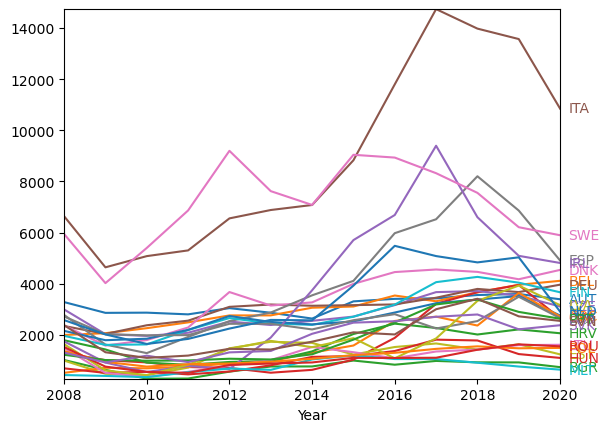

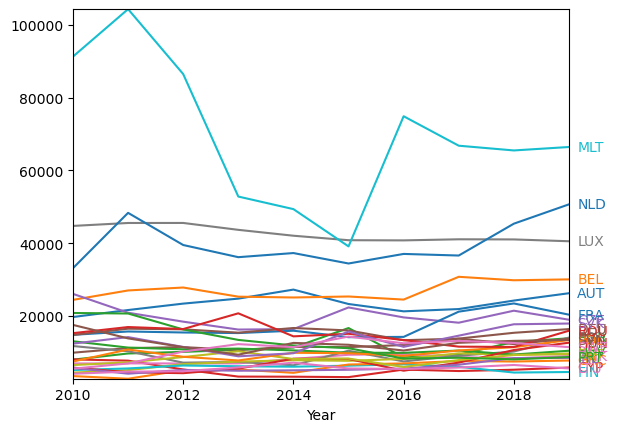

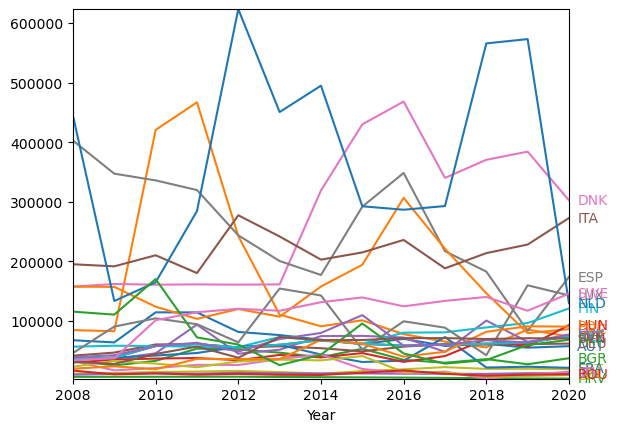

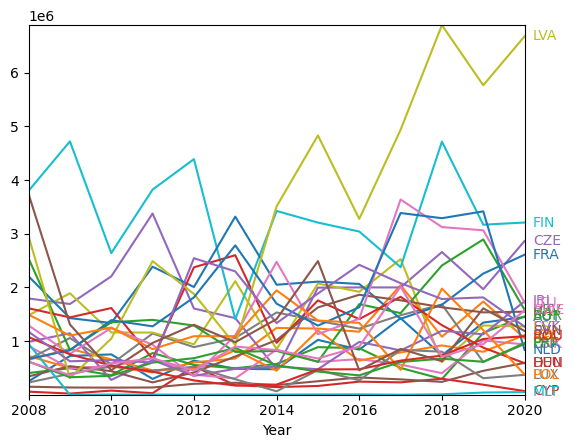

In [316]:
# CHECKS: Prices
if aggregated_output == False:
    lineplot_annotated(p_c_buildings.T)
    lineplot_annotated(p_c_roads.T)
    lineplot_annotated(p_c_railways.T)
    lineplot_annotated(p_c_electricity.T)

## Disaggregation of output to intermediate and final demand

In [317]:
# Total output of c

#For disaggregation of Y_crow, Z_crow, and Z_ccol
x_crow_sub_shares = pd.read_csv('processed_data/x_crow_sub_shares'+agg+building_mi_source+transport_stocks+'.csv', index_col=[0,1,2]).squeeze('columns').loc[iot_year] #TODO: rename y_c_sub_mon_shares in original file
x_crow_sub_shares[x_crow_sub_shares<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material
#NOTE: does not contain greenhouses

# For comparison with MRIOT-based estimates of x_crow_sub
x_crow_sub = pd.read_csv('processed_data/x_crow_sub'+agg+building_mi_source+transport_stocks+'.csv', index_col=[0,1,2]).squeeze('columns').loc[iot_year] #TODO: rename y_c_sub_mon in original file
x_crow_sub[x_crow_sub<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material
#NOTE: contains greenhouses

x_crow_sub_phys = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv', header=0) #index_col=[1,2,4,5,6,7]
x_crow_sub_phys.replace('stock', 'replacement', inplace=True) 
x_crow_sub_phys.set_index(['Year', 'Country', 'Structure', 'Value_process', 'Unit'], inplace=True)
x_crow_sub_phys.sort_index(inplace=True)
x_crow_sub_phys.drop(columns=['Value_source'], inplace=True)
x_crow_sub_phys = x_crow_sub_phys.loc[iot_year]
x_crow_sub_phys[x_crow_sub_phys<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material



### Output to intermediate demand & household final demand (maintenance and repair work)

In [318]:
### INTERMEDIATE OUTPUT

#disaggregation of intermediate demand for EU construction based on total output shares
Z_crow_eu = Z_crow.loc[eu_labels,:]

x_crow_sub_shares_wide = pd.concat([x_crow_sub_shares]*r*s, axis=1)
x_crow_sub_shares_wide.columns = Z_crow_eu.columns

Z_crow_sub_eu = multiply_subcategories(x_crow_sub_shares_wide, Z_crow_eu)

if zmatching == '_zmatching': #matching intermediate demand by other sectors with the respective construction subsector
    for sector, subsectors in {'Real estate activities':['Buildings'],
                'Land transport and transport via pipelines': ['Roads', 'Railways', 'Other civil engineering'],
                'Electricity, gas, steam and air conditioning supply':['Electricity']}.items():
        Z_crow_sub_eu.loc[:, (slice(None), sector)] = 0
        for subsector in subsectors:
            Z_crow_sub_eu.loc[(slice(None),subsector), (slice(None), sector)] = Z_crow_eu.loc[:, (slice(None), sector)].mul(x_crow_sub_shares.unstack().div((x_crow_sub_shares.unstack()[subsectors]).sum(1), axis=0)[subsector], axis=0).assign(sector=subsector).set_index('sector', append=True).reorder_levels(['region', 'sector'])

Z_crow_sub_eu.index.set_names(['region', 'subsector'], inplace=True)
Z_crow_sub_eu = Z_crow_sub_eu.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector'])

#insert Z_crow_sub_eu into Z
Z_subrow = Z.copy()
Z_subrow = Z_subrow.assign(subsector='Total').set_index('subsector', append=True)
Z_subrow = Z_subrow.append(Z_crow_sub_eu).sort_index() #this is creating a different sorting than columns
Z_subrow = Z_subrow.drop(index=Z_subrow.loc[pd.IndexSlice[eu_labels,c,'Total'],:].index)

#Check
len(Z_subrow) == r*s -len(eu_labels) + len(eu_labels)*n

#Export
Z_subrow.replace(np.nan, 0, inplace=True)
Z_subrow.to_csv('processed_data/Z_subrow'+agg+building_mi_source+transport_stocks+zmatching+'.csv')


/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/2155692178.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### Output to gross fixed capital formation in final demand

In [319]:
# MONETARY TABLE: Disaggregation

### FINAL DEMAND

# Disaggregation of final demand for EU construction based on total output shares
Y_crow_eu = Y_crow.loc[eu_labels,:]

x_crow_sub_shares_wide = pd.concat([x_crow_sub_shares]*r*d, axis=1)
x_crow_sub_shares_wide.columns = Y_crow_eu.columns

Y_crow_sub_eu = multiply_subcategories(x_crow_sub_shares_wide, Y_crow_eu)

Y_crow_sub_eu.index.set_names(['region', 'subsector'], inplace=True)
Y_crow_sub_eu = Y_crow_sub_eu.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector'])

#insert Y_crow_sub_eu into Y
Y_sub = Y.copy()
Y_sub = Y_sub.assign(subsector='Total').set_index('subsector', append=True)
Y_sub = Y_sub.append(Y_crow_sub_eu).sort_index() #this is creating a different sorting than columns
Y_sub = Y_sub.drop(index=Y_sub.loc[pd.IndexSlice[eu_labels,c,'Total'],:].index)

#Check
len(Y_sub) == r*s -len(eu_labels) + len(eu_labels)*n

#Export
Y_sub.replace(np.nan, 0, inplace=True)
Y_sub.to_csv('processed_data/Y_sub'+agg+building_mi_source+transport_stocks+'.csv') #output: Final demand in all countries disaggregated for construction in EU countries

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/2563611431.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### Total output by subsector

In [320]:
Y_sub = pd.read_csv('processed_data/Y_sub'+agg+building_mi_source+transport_stocks+'.csv', index_col=[0,1,2], header=[0,1]) #million $
Z_subrow = pd.read_csv('processed_data/Z_subrow'+agg+building_mi_source+transport_stocks+zmatching+'.csv', index_col=[0,1,2], header=[0,1]) #million $

x_crow_sub_summary = (Y_sub.sum(1).groupby(level=2).sum()+Z_subrow.sum(1).groupby(level=2).sum()).drop('Total') #million $
x_crow_sub_summary.to_csv('processed_data/x_crow_sub_summary'+agg+building_mi_source+transport_stocks+zmatching+'.csv')

x_crow_sub_eu_icio = (Y_sub.sum(1).groupby(level=[0,2]).sum()+Z_subrow.sum(1).groupby(level=[0,2]).sum()).drop('Total', level=1).unstack(1)
if aggregated_output == True:
    x_crow_sub_eu_icio = x_crow_sub_eu_icio.sort_values('Buildings', ascending=False) #million $
else:
    x_crow_sub_eu_icio = x_crow_sub_eu_icio.sort_values('Buildings, dwelling single', ascending=False)
x_crow_sub_eu_icio.to_csv('processed_data/x_crow_sub_eu_icio'+agg+building_mi_source+transport_stocks+zmatching+'.csv')

In [321]:
#DESCRIPTIVE STATISTICS: total output and distribution of total output
print((Y_sub.loc[pd.IndexSlice[eu_labels,c,:],eu_labels].xs('GFCF', axis=1, level=1).sum(1)/x_crow_sub_eu_icio.stack()).unstack(1).describe())
print(x_crow_sub_shares.unstack(1).describe())
x_crow_sub_shares.unstack(1)

subsector  Buildings, dwelling multi  Buildings, dwelling single  \
count                          27.00                       27.00   
mean                            0.61                        0.61   
std                             0.11                        0.11   
min                             0.42                        0.42   
25%                             0.53                        0.53   
50%                             0.61                        0.61   
75%                             0.69                        0.69   
max                             0.83                        0.83   

subsector  Buildings, education  Buildings, offices  Buildings, other  \
count                     27.00               27.00             27.00   
mean                       0.61                0.61              0.61   
std                        0.11                0.11              0.11   
min                        0.42                0.42              0.42   
25%                   

sector,"Buildings, dwelling multi","Buildings, dwelling single","Buildings, education","Buildings, offices","Buildings, other","Buildings, wholesale and retail","Electricity, combustible fuels","Electricity, hydro","Electricity, nuclear and other fuels","Electricity, other renewables","Electricity, solar photovoltaic","Electricity, wind",Other civil engineering,Railways,"Roads, communal","Roads, motorway","Roads, provincial","Roads, state"
region,,,,,,,,,,,,,,,,,,
AUT,0.23,0.25,0.03,0.02,0.17,0.03,0.00,0.01,0.00,0.00,0.00,0.01,0.05,0.01,0.07,0.01,0.09,0.02
BEL,0.22,0.25,0.05,0.02,0.16,0.07,0.00,0.00,0.00,0.00,0.01,0.01,0.12,0.01,0.04,0.01,0.02,0.01
BGR,0.12,0.14,0.07,0.03,0.14,0.08,0.02,0.00,0.00,0.00,0.00,0.00,0.10,0.03,0.15,0.01,0.08,0.03
CYP,0.34,0.38,0.05,0.02,0.09,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.02,0.00,0.02,0.01
CZE,0.15,0.17,0.07,0.03,0.15,0.06,0.03,0.00,0.01,0.00,0.00,0.00,0.08,0.05,0.08,0.01,0.08,0.03
DEU,0.20,0.23,0.09,0.03,0.16,0.06,0.01,0.00,0.00,0.00,0.00,0.00,0.10,0.01,0.04,0.01,0.05,0.02
DNK,0.15,0.17,0.08,0.04,0.29,0.07,0.00,0.00,0.00,0.00,0.00,0.01,0.11,0.03,0.03,0.00,0.01,0.00
ESP,0.25,0.29,0.04,0.02,0.14,0.08,0.01,0.00,0.00,0.00,0.00,0.01,0.03,0.03,0.03,0.01,0.04,0.01
EST,0.09,0.10,0.08,0.04,0.24,0.08,0.05,0.00,0.00,0.00,0.00,0.00,0.10,0.01,0.11,0.00,0.04,0.03


## Preparation of material intensity model inputs

### Which inputs to focus disaggregation effort on?

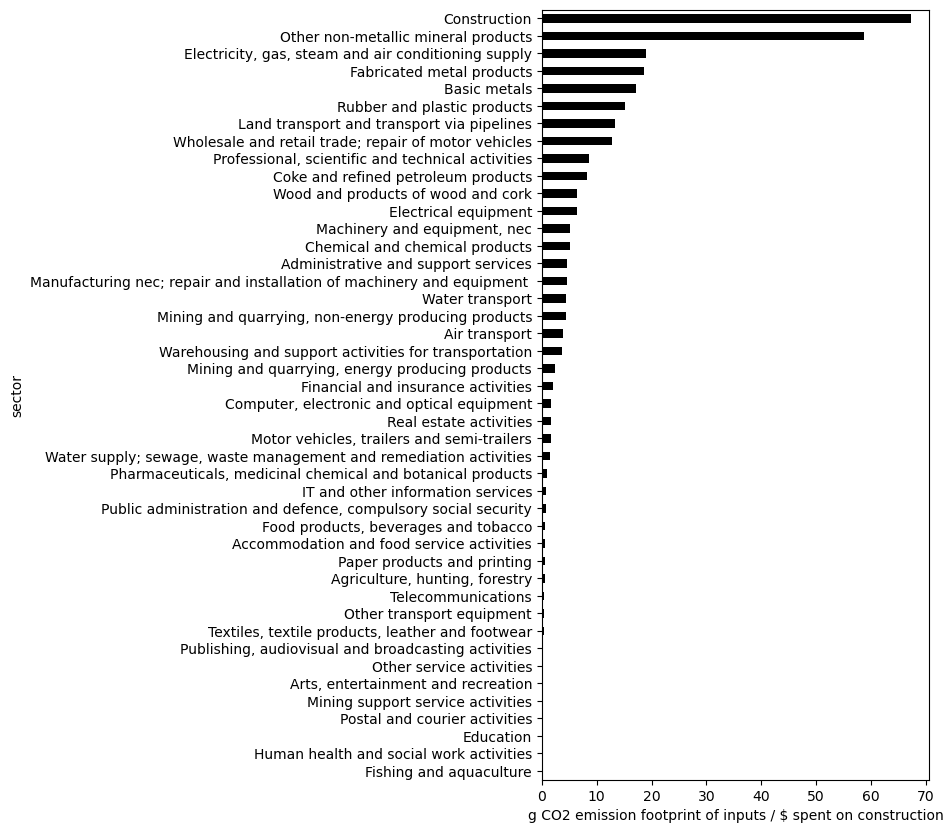

In [322]:
I = np.identity(r*s)
x_0_ = x.copy() 
x_0_[x_0_!=0] = 1/x_0_[x_0_!=0]
inv_diag_x_0 = np.diag(x_0_) 
A_0 = Z@inv_diag_x_0 #MNxMN  ##Checked: np.allclose(x_0, A_0@x_0 + y_0)
A_0.columns = Z.columns
A_0 = A_0.astype(float)
L_0 = np.linalg.inv(I-A_0)

mult_sector = f @ L_0
mult_sector.columns = A_0.columns

mult_sector_sum = mult_sector.groupby(level=1, axis=1, sort=False).mean() 

A_mean = A_0.xs(c, level=1,axis=1).groupby(level=1,axis=0,sort=False).sum()[eu_labels]

((A_mean.mean(1)*mult_sector_sum.T.loc[:,f_label]).sort_values()*1e6)[1:].plot(kind='barh', figsize=(5,10), color='black')
plt.xlabel('g CO2 emission footprint of inputs / $ spent on construction')
plt.savefig('images/bars_mult_c_sector_sum.png')

### Intensity of specified inputs

In [323]:
eu_labels_full = coco.CountryConverter().EU27.name_short.to_list()
eu_labels_full.append('Europe')
eu_labels_full.append('South European Countries')
eu_labels_full.append('South European Countries ')
eu_labels_full.append('North European countries')
eu_labels_full.append('Central European countries')

#INITIALISE DATAFRAME
mi_df = pd.DataFrame(columns=['Year', 'Region', 'Structure', 'Material', 'Value', 'Value_source', 'Value_samplesize', 'Value_process', 'Unit'])

#### Buildings

In [324]:
if building_mi_source == '_rasmi':
    #FISHMAN ET AL. 2024: Material Intensity Database with partially synthetic (ML-generated) data
    rasmi_d = pd.read_excel('external_data/240501_Fishman_RASMI_Buildings_MI_ranges_20230905.xlsx', sheet_name=None, index_col=0, header=0) ##################################
    rasmi_df = pd.DataFrame()
    for k, rasmi in rasmi_d.items():
        rasmi = rasmi[rasmi['R5_32'].isin(['OECD_EEU', 'OECD_EFTA', 'OECD_EU12-H', 'OECD_EU12-M', 'OECD_EU15','REF_EEU-FSU'])]
        structure_shares = 1/rasmi.groupby(by=['function', 'structure']).sum(numeric_only=True).increment_iterations.unstack(1).div(rasmi.groupby(by=['function']).sum(numeric_only=True).increment_iterations, axis=0)
        structure_shares = structure_shares.div(structure_shares.sum(1), axis=0).stack() #assumption: prevalence of each building structure type (e.g. wood-frame structure, concrete structure) is indicated by the prevalence among MSA studies
        rasmi = rasmi.set_index(['function', 'structure','R5_32']).drop(['R5','raw_HF_db_count', 'increment_iterations', 'incremented_count'], axis=1)
        rasmi = rasmi.multiply(structure_shares.reindex(rasmi.index, method='ffill'), axis=0).groupby(axis=0, level=[0,2]).sum(numeric_only=True)
        rasmi.rename(index={'NR': 'Buildings, non-residential', 'RM': 'Buildings, dwelling multi', 'RS': 'Buildings, dwelling single'}, inplace=True)
        rasmi_df[k] = rasmi[building_mi_range]
    rasmi_df.columns = [i.capitalize() for i in rasmi_df.columns]
    rasmi_df = rasmi_df.stack().reset_index()
    rasmi_df.columns = ['Structure', 'Region', 'Material', 'Value']
    mi_df = pd.merge(rasmi_df, mi_df, how='outer')
    mi_df['Value_source'] = 'Fishman et al. 2024'
    mi_df['Value_samplesize'] = 30
    mi_df['Value_process'] = 'expansion (& replacement)'
    mi_df['Unit'] = 'kg/m2'
else:
    #RÖCK ET AL. 2024: CARBENMATS-BUILDINGS LCA-Database including material intentisities
    cem = pd.read_excel('external_data/240307_Roeck_MatIntensity_Buildings_carbenmats-buildings-7557e1f/CarbEnMats_dataset.xlsx', header=0, index_col=1, na_values='No data') ##############################################
    cem.drop(cem.columns[0], axis=1, inplace=True)

    cem_materials = pd.read_excel('external_data/240307_Roeck_MatIntensity_Buildings_carbenmats-buildings-7557e1f/CarbEnMats_materials.xlsx', header=1, skiprows=0,skipfooter=5, usecols=[0,1]) ##############################################
    cem_materials['related attribute (secondary)'] = [i[2:] for i in cem_materials['related attribute (secondary)']]
    materials = cem_materials.set_index('inv_mat_*_type').to_dict()['related attribute (secondary)'] #cem_materials['inv_mat_*_type'].to_list()

    mi = []
    for material, matlab in materials.items():
        mi.append('mi_'+str(matlab))

    d_mi = {}
    d_mi = d_mi.fromkeys(mi, 0)

    cem_mi = cem.dropna(how='all', subset=mi)

    #adding another 16 point estimates of material intensity in non-residential buildings
    deetman_mi = pd.read_excel('external_data/240212_Deetman_2020_MatIntensity_Nonresidential/1-s2.0-S0959652619335280-mmc1.xlsx', header=None, names=['bldg_use_subtype', 'admin_data_partner','description', 'site_country', 'mi_steel_reinforcement', 'mi_concrete_reinforced', 'mi_aluminium', 'mi_brass_copper', 'mi_wood', 'mi_glass'], skiprows=1, skipfooter=1) ##############################################
    deetman_mi.replace('Offices', 'Office', inplace=True)
    deetman_mi.replace('Retail+', 'Retail and Restaurant', inplace=True)
    deetman_mi.replace('Hotels+', 'Hotel & Resort', inplace=True)
    deetman_mi.drop('description', axis=1, inplace=True)
    deetman_mi.loc[13:14, 'bldg_use_subtype'] = 'School and Daycare'
    deetman_mi.loc[15, 'bldg_use_subtype'] = 'Hospital and Health'
    deetman_mi.loc[16, 'bldg_use_subtype'] = 'School and Daycare'

    cem_mi = pd.merge(cem_mi, deetman_mi, how='outer')

    #adding another set of point estimates of material intensity in residential buildings, Western Europe
    marinova_mi = pd.read_excel('external_data/240212_Marinova_2020_MatIntensity_Residential/Marinova_2020_MatIntensity_Residential.xlsx', sheet_name='Region 11', header=None, usecols=[1,4,8,9,11,18,22], names=['admin_data_partner','site_country', 'bldg_use_subtype', 'index','bldg_year_complete_interval', 'material', 'mi'], skiprows=1) ##############################################
    marinova_mi[['site_city', 'site_country']] = marinova_mi['site_country'].str.split(', ', n=1, expand=True)
    marinova_mi['site_country'] = np.where((marinova_mi['site_city']=='South European Countries')|(marinova_mi['site_city']=='South European Countries ') | (marinova_mi['site_city']=='Central European countries')| (marinova_mi['site_city']=='North European countries') | (marinova_mi['site_city']=='Sweden') | (marinova_mi['site_city']=='UK'), marinova_mi['site_city'], marinova_mi['site_country'])
    marinova_mi['site_country'] = np.where(marinova_mi['site_city']=='Scotland','UK', marinova_mi['site_country'])
    marinova_mi.drop('site_city', axis=1, inplace=True)
    marinova_mi.replace(['Detached house', 'Detached house '], 'Single family house', inplace=True)
    marinova_mi.replace(['Apartment building ', 'High-rise building'], 'Multi-family house', inplace=True)
    marinova_mi.replace('Aluminium', 'mi_aluminium', inplace=True)
    marinova_mi.replace('Wood', 'mi_wood', inplace=True)
    marinova_mi.replace('Concrete', 'mi_concrete_reinforced', inplace=True)
    marinova_mi.replace('Glass', 'mi_glass', inplace=True)
    marinova_mi.replace('Copper', 'mi_brass_copper', inplace=True)
    marinova_mi.replace('Steel', 'mi_steel_reinforcement', inplace=True)
    marinova_mi = marinova_mi.pivot(index=['index', 'admin_data_partner', 'site_country', 'bldg_use_subtype','bldg_year_complete_interval'] , columns='material', values='mi')
    marinova_mi.reset_index(inplace=True)
    marinova_mi.drop('index', axis=1, inplace=True)

    cem_mi = pd.merge(cem_mi, marinova_mi, how='outer')


    #adding another set of point estimates of material intensity in residential buildings, Eastern Europe
    marinova_mi = pd.read_excel('external_data/240212_Marinova_2020_MatIntensity_Residential/Marinova_2020_MatIntensity_Residential.xlsx', sheet_name='Region 12', header=None, usecols=[1,4,8,9,11,18,22], names=['admin_data_partner','site_country', 'bldg_use_subtype', 'index','bldg_year_complete_interval', 'material', 'mi'], skiprows=1) ##############################################
    marinova_mi.replace(['Detached house', 'Detached house '], 'Single family house', inplace=True)
    marinova_mi.replace(['Apartment building ', 'High-rise building'], 'Multi-family house', inplace=True)
    marinova_mi.replace('Aluminium', 'mi_aluminium', inplace=True)
    marinova_mi.replace('Wood', 'mi_wood', inplace=True)
    marinova_mi.replace('Concrete', 'mi_concrete_reinforced', inplace=True)
    marinova_mi.replace('Glass', 'mi_glass', inplace=True)
    marinova_mi.replace('Copper', 'mi_brass_copper', inplace=True)
    marinova_mi.replace('Steel', 'mi_steel_reinforcement', inplace=True)
    marinova_mi = marinova_mi.pivot(index=['index', 'admin_data_partner', 'site_country', 'bldg_use_subtype','bldg_year_complete_interval'] , columns='material', values='mi')
    marinova_mi.reset_index(inplace=True)
    marinova_mi.drop('index', axis=1, inplace=True)

    cem_mi = pd.merge(cem_mi, marinova_mi, how='outer')

    cem_mi.fillna(d_mi, inplace=True)

    cem_mi['bldg_year_complete_interval'] = cem_mi['bldg_year_complete_interval'].str[-4:]
    cem_mi.replace('970s', '1980', inplace=True)
    cem_mi.drop(98, axis=0, inplace=True) #removing an outlier which had 100 times higher aluminium and plastic intensity

    cem_mi.groupby(['bldg_use_subtype']).mean(numeric_only=True).loc[:,mi]

    cem_mi_out = cem_mi.copy()
    cem_mi_out.replace('Row house', 'Multi-family house', inplace=True)
    cem_mi_out.replace('Semi-detached', 'Multi-family house', inplace=True)
    cols = mi.copy()
    cols.append('bldg_use_subtype')
    cols.append('bldg_year_complete_interval')
    cols.append('site_country')
    cem_mi_out = cem_mi_out.loc[:,cols]
    cem_mi_out.reset_index(inplace=True)
    cem_mi_out.replace(['Denmark', 'Sweden', 'Finland', 'North European countries'], 'Northern Europe', inplace=True)
    cem_mi_out.replace(['Spain', 'Italy', 'France', 'Turkey', 'South European Countries', 'South European Countries '], 'Southern Europe', inplace=True)
    cem_mi_out.replace(['Austria', 'UK', 'UK ', 'United Kingdom','Belgium', 'Switzerland', 'Germany', 'Poland', 'Central European countries'], 'Central Europe', inplace=True)
    cem_mi_out.replace(['Singapore', 'China', 'Canada','Brazil', 'USA', 'Australia', 'South Korea', 'Mexico', 'Thailand', 'Japan', 'Sri Lanka', '-'], 'Other', inplace=True)
    l = pd.wide_to_long(cem_mi_out, stubnames='mi', i=['index', 'bldg_use_subtype', 'bldg_year_complete_interval', 'site_country'], j='material', sep='_', suffix=r'\w+')
    l.reset_index(inplace=True)
    l.replace(0, np.NaN, inplace=True)
    l.replace(['concrete_wo_reinforcement', 'concrete_reinforced'], 'concrete', inplace=True)
    l.replace('bamboo', 'wood', inplace=True)
    l.replace('EPS_XPS', 'plastics', inplace=True)
    l.replace(['steel_reinforcement','metals'], 'steel', inplace=True)
    l.bldg_year_complete_interval = l.bldg_year_complete_interval.astype(float)

    #minimum threshold for sample size for calculation of median material intensity
    for i, v in cem_mi_out.groupby(by=['bldg_use_subtype']).size().items():
        if v < 5:
            l.replace(i, 'Other', inplace=True)
            cem_mi_out.replace(i, 'Other', inplace=True)

    l_detail = l.groupby(by=['bldg_use_subtype', 'site_country', 'material']).median(numeric_only=True).sort_index()
    l_global = l.groupby(by=['bldg_use_subtype', 'material']).median(numeric_only=True).sort_index()
    l_mi = pd.DataFrame(columns = l_detail.columns, index=l_detail.index)
    l_mi = l_mi.sort_index()
    for (i,j), v in cem_mi_out.groupby(by=['bldg_use_subtype', 'site_country']).size().items():
        if v >= 5:
            for m in l.material.unique():
                l_mi.loc[(i,j,m)] = l_detail.loc[(i,j,m)]
                l_mi.loc[(i,j,m), 'Value_samplesize'] = v
        else:
            for m in l.material.unique():
                l_mi.loc[(i,'Global',m)] = l_global.loc[(i,m)]
                l_mi.loc[(i,'Global',m), 'Value_samplesize'] = cem_mi_out.groupby(by=['bldg_use_subtype']).size().loc[i]

    l_mi = l_mi.dropna(axis=0, how='all')
    l_mi['Value_samplesize'] = l_mi['Value_samplesize'].astype(int)

    l_mi = l_mi.drop(['index', 'bldg_year_complete_interval'], axis=1)
    l_mi.reset_index(inplace=True)
    l_mi.columns = ['Structure', 'Region', 'Material', 'Value', 'Value_samplesize']
    mi_df = pd.merge(l_mi, mi_df, how='outer')
    mi_df['Value_source'] = 'Röck et al. 2024, Deetman et al. 2021, Marinova et al. 2021'
    mi_df['Value_process'] = 'expansion (& replacement)'
    mi_df['Unit'] = 'kg/m2'

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/4011606217.py:49: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/4011606217.py:136: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/4011606217.py:136: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/4011606217.py:136: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/4011606217.py:136: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/4011606217.py:136: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/

#### Transport infrastructure

In [325]:
# TRIPI alternative
if transport_mi_source == '_tripi':
    tripi_mat = pd.read_excel('/Volumes/My Passport for Mac/TRIPI-main/TRIPI-Final-Materials/total_materials.xlsx', sheet_name='all_parts_country_part', index_col=[0,1], header=0)
    tripi_mi = tripi_mat / tripi_stocks
    

In [326]:
#import dataframe

wiedenhofer_mi = pd.read_excel('external_data/240212_Wiedenhofer_2024_MobilityInfrastructure_2021 - full supplementary data.xlsx', sheet_name='MI', index_col=[0,1], header=[0,1], skiprows=3, skipfooter=4, na_values='                        -  ') ##############################################

wiedenhofer_mi = wiedenhofer_mi.droplevel(0, axis=0)
wiedenhofer_mi.fillna(0, inplace=True)
wiedenhofer_mi = wiedenhofer_mi.astype(float)
widths = wiedenhofer_mi.xs('Width', axis=1, level=1)
wiedenhofer_mi = wiedenhofer_mi.drop('Width', axis=1, level=1)
wiedenhofer_mi = wiedenhofer_mi.drop('Total', axis=1, level=1)

#multiply width per country with material intensity to get to t/m
for i in wiedenhofer_mi.columns.levels[0].to_list():
    wiedenhofer_mi[(i,)] = wiedenhofer_mi.xs(i, axis=1, level=0).mul(widths[i], axis=0)

wiedenhofer_mi = wiedenhofer_mi*1000000 #multiply by 1000 to have kg/m, multiply by 1000 again to have kg/km

wiedenhofer_mi.drop('Runways (flexible) **', axis=0, inplace=True)
wiedenhofer_mi.drop('Runways (rigid) **', axis=0, inplace=True)
wiedenhofer_mi

#expansion
wiedenhofer_mi = wiedenhofer_mi.drop(['China', 'GCC', 'Japan', 'Nepal', 'South Africa', 'Turkey', 'USA'], axis=1, level=0)

w = wiedenhofer_mi.stack().stack()
w = w.reset_index()
w.replace(0, np.NaN, inplace=True)
w.columns = ['Structure', 'Material', 'Region', 'Value']
w['Region'] = coco.CountryConverter().convert(w['Region'], to='ISO3')
w.replace('not found', 'Global', inplace=True)

w['Value_source'] = 'Wiedenhofer et al. 2024'
w['Value_process'] = 'expansion'
w['Unit'] = 'kg/km'
w['Year'] = 2021
mi_df = pd.merge(w, mi_df, how='outer')
mi_df

#maintenance
lifetimes = pd.DataFrame(index=wiedenhofer_mi.index)
lifetimes['Iron'] = [np.NaN]*6 + [120]*4 + [30] + [120]*5 + [30] ##############################################
lifetimes['Concrete'] = [33]*6 + [120]*4 + [50] + [120]*5 + [50] ##############################################
lifetimes['Asphalt'] = [21]*6 + [np.NaN]*11 ##############################################
lifetimes['Aggregate'] = [120]*17 ##############################################
lifetimes['Timber'] = [np.NaN]*6 + [np.NaN]*4 + [50] + [np.NaN]*5 + [50] ##############################################
lifetimes['Other'] = [np.NaN]*6 + [120]*4 + [50] + [120]*5 + [50] ##############################################

wiedenhofer_mi.columns = wiedenhofer_mi.columns.swaplevel(0, 1)
wiedenhofer_mi.sort_index(axis=1, level=0, inplace=True)

for i in ['Aggregate', 'Asphalt', 'Concrete', 'Iron', 'Other', 'Timber']:
    wiedenhofer_mi[(i)] = wiedenhofer_mi.xs(i, axis=1, level=0).div(lifetimes[i], axis=0)

wiedenhofer_mi.columns = wiedenhofer_mi.columns.swaplevel(0, 1)
wiedenhofer_mi.sort_index(axis=1, level=0, inplace=True)
w = wiedenhofer_mi.stack().stack()
w = w.reset_index()
w.replace(0, np.NaN, inplace=True)
w.columns = ['Structure', 'Material', 'Region', 'Value']
w['Region'] = coco.CountryConverter().convert(w['Region'], to='ISO3')
w.replace('not found', 'Global', inplace=True)

w['Value_source'] = 'Wiedenhofer et al. 2024'
w['Value_process'] = 'replacement'
w['Unit'] = 'kg/km'
w['Year'] = 2021

mi_df = pd.merge(w, mi_df, how='outer')

recycling_percentage_roads_aggregate = 0.7 #based on informal conversation with road engineer in NL ##############################################
recycling_percentage_roads_asphalt = 0.3 #based on informal conversation with road engineer in NL ##############################################
residual_percentage_roads = (25/100*1000)/w[(w['Structure']=='Motorway') & (w['Value_process']=='replacement') & (w['Region']=='Global')].Value.sum() #residual percentage, extra material not incorporated into the road, 25 tonnes per 100km based on inquiry with NL road constructors ##############################################

mi_df.loc[mi_df['Unit']=='kg/km', 'Value'] = mi_df.loc[mi_df['Unit']=='kg/km', 'Value']/(1-residual_percentage_roads)
mi_df.loc[(mi_df['Unit']=='kg/km') & (mi_df['Material']=='Aggregate'), 'Value'] = mi_df.loc[(mi_df['Unit']=='kg/km') & (mi_df['Material']=='Aggregate'), 'Value']*(1-recycling_percentage_roads_aggregate)
mi_df.loc[(mi_df['Unit']=='kg/km') & (mi_df['Material']=='Asphalt'), 'Value'] = mi_df.loc[(mi_df['Unit']=='kg/km') & (mi_df['Material']=='Asphalt'), 'Value']*(1-recycling_percentage_roads_asphalt)

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/182507840.py:14: PerformanceWarning:

indexing past lexsort depth may impact performance.

Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average *

#### Electricity Generation Capacity

In [327]:
from read_mym import read_mym_df

# IMAGE file: Generation capacity (stock) in MW peak capacity (Used as proxy for grid growth)
gcap_BL_data = read_mym_df('external_data/240212_Deetman_2020_MatIntensity_Electricity/Gcap.out')
gcap_BL_data = gcap_BL_data.loc[gcap_BL_data['DIM_1'].isin([11,12])]
gcap_BL_data.DIM_1 = gcap_BL_data.DIM_1.replace(11,'Western Europe')
gcap_BL_data.DIM_1 = gcap_BL_data.DIM_1.replace(12,'Central Europe')
gcap_BL_data.time = gcap_BL_data.time.astype(str)
gcap_total = gcap_BL_data.set_index(['time', 'DIM_1']).loc[:,29].sort_index().rename_axis(['year', 'region']).loc['2016'] #only selecting total generation capacity


grid_m = pd.read_csv('external_data/240212_Deetman_2020_MatIntensity_Electricity/grid_materials_output_kt.csv', index_col=[0,1,2,3,4,5], header=0)
grid_m = grid_m.loc[pd.IndexSlice[grid_m.index.isin(['Western Europe','Central Europe'], level=0),'stock', :,:,:,:]]
grid_m = grid_m.groupby(axis=0, level=[0,5]).sum().stack().unstack(1).reorder_levels([1,0]).sort_index().rename_axis(['year', 'region']).loc['2016']

grid_mi = grid_m.div(gcap_total, axis=0)*1e6 #kg per MW

deetman_mi = pd.read_csv('external_data/240212_Deetman_2020_MatIntensity_Electricity/composition_generation.csv', header=0, index_col=[0,1]) ##############################################
deetman_mi.drop(2050, axis=0, level=0, inplace=True)
deetman_mi = deetman_mi/1000 #from g/MW to kg/MW
deetman_mi.drop('<EMPTY>', axis=0, level=1, inplace=True)
deetman_mi = deetman_mi.add(grid_mi.mean(0)) #TODO: differentiate between Western Europe and Central Europe
d_mi = deetman_mi.stack()
d_mi = d_mi.reset_index()
d_mi.replace('Cu', 'Copper', inplace=True)
d_mi.replace('Pb', 'Lead', inplace=True)
d_mi.replace('Co', 'Cobalt', inplace=True)
d_mi.columns = ['Year', 'Structure', 'Material', 'Value']
d_mi['Value_source'] = 'Deetman et al. 2021'
d_mi['Value_process'] = 'expansion (& replacement)'
d_mi['Unit'] = 'kg/MW peak'
d_mi['Region'] = 'Global'
mi_df = pd.merge(d_mi, mi_df, how='outer')

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/873351854.py:33: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



#### Harmonise and apply residual percentages

In [328]:
replacement_map = {'Concrete':'Other non-metallic mineral products_Concrete',
 'Aggregate':'Other non-metallic mineral products_Stone', #ambiguous category: could also be classified as sand in 'Mining and quarrying, non-energy producing products_Earth'
 'Iron':'Fabricated metal products_Steel',
 'Other':'Basic metals_Other',
 'Asphalt':'Other non-metallic mineral products_Asphalt concrete',
 'Timber':'Wood and products of wood and cork_Timber',
 'Lead':'Basic metals_Lead',
 'Aluminium':'Basic metals_Aluminium',
 'Aluminum':'Basic metals_Aluminium',
 'Steel':'Fabricated metal products_Steel',
 'Cobalt':'Basic metals_Other',
 'Nd':'Basic metals_Other',
 'Copper':'Basic metals_Copper',
 'Glass':'Other non-metallic mineral products_Glass',
 'Plastics':'Rubber and plastic products_Plastics',
 'fungi':'Wood and products of wood and cork_Other',
 'straw_hemp':'Wood and products of wood and cork_Other',
 'stone_wool':'Other non-metallic mineral products_Stone wool',#
 'stone':'Other non-metallic mineral products_Stone',
 'steel':'Fabricated metal products_Steel',
 'plastics':'Rubber and plastic products_Plastics',
 'other':'Basic metals_Other',
 'glass':'Other non-metallic mineral products_Glass',
 'earth':'Mining and quarrying, non-energy producing products_Earth',
 'concrete':'Other non-metallic mineral products_Concrete',
 'ceramics':'Other non-metallic mineral products_Bricks',
 'cement_mortar':'Other non-metallic mineral products_Mortar',
 'brass_copper':'Basic metals_Copper',
 'aluminium':'Basic metals_Aluminium',
 'wood':'Wood and products of wood and cork_Timber',
 'Brick': 'Other non-metallic mineral products_Bricks',
 'Wood':'Wood and products of wood and cork_Timber'}

print(len(mi_df.Material.value_counts().index.to_list()) == len(replacement_map))

mi_df['Material_group'] = mi_df['Material'].map(replacement_map)


replacement_map = {'Single family house':'Buildings, dwelling single',
                    'Multi-family house':'Buildings, dwelling multi',
                    'Office': 'Buildings, offices',
                    'Railway':'Railways', 
                    'Tram and other rails':'Railways, local',
                    'Subway underground':'Railways, local',
                    'Subway elevated':'Railways, local',
                    'Subway ground-level':'Railways, local',
                    'School and Daycare':'Buildings, education',
                    'Retail and Restaurant': 'Buildings, wholesale and retail',
                    'Greenhouses':'Buildings, greenhouses', #not used anymore
                    'Mixed use':'Buildings, other', #not used anymore
                    'Other':'Buildings, other',
                    'Hospital and Health':'Buildings, other', #not used anymore
                    'Hotel & Resort': 'Buildings, other', #not used anymore
                    'Buildings, non-residential': 'Buildings, non-residential', #rasmi
                    'Buildings, dwelling multi':'Buildings, dwelling multi' , #rasmi
                    'Buildings, dwelling single':'Buildings, dwelling single', #rasmi
                    'Local':'Roads, communal',
                    'Rural':'Roads, provincial',
                    'Primary':'Roads, state',
                    'Secondary':'Roads, state',
                    'Tertiary':'Roads, state',
                    'Motorway':'Roads, motorway',
                    'Other road':'Roads, state', #not used anymore
                    'Motorway bridges':'Roads, motorway bridges',
                    'Motorway tunnels':'Roads, motorway tunnels',
                    'Other road bridges':'Roads, state bridges',
                    'Other road tunnels':'Roads, state tunnels',
                    'Railway bridges':'Railways bridges',
                    'Railway tunnels':'Railways tunnels',
                    'Nuclear': 'Electricity, nuclear and other fuels',
                    'Other renewables':'Electricity, other renewables', #not used anymore
                    'Other Renewables':'Electricity, other renewables',
                    'Solar PV':'Electricity, solar photovoltaic',
                    'CSP':'Electricity, solar CSP',
                    'Wind onshore':'Electricity, wind',
                    'Wind offshore':'Electricity, wind',
                    'Hydro':'Electricity, hydro',
                    'Conv. Coal':'Electricity, combustible fuels', 
                    'Conv. Oil':'Electricity, combustible fuels',
                    'Conv. Natural Gas':'Electricity, combustible fuels',
                    'CHP Coal':'Electricity, combustible fuels',
                    'CHP Oil':'Electricity, combustible fuels',
                    'CHP Natural Gas':'Electricity, combustible fuels',
                    'CHP Biomass':'Electricity, combustible fuels',
                    'Waste':'Electricity, combustible fuels',
                    'IGCC':'Electricity, combined cycle',
                    'OGCC':'Electricity, combined cycle',
                    'NG CC':'Electricity, combined cycle',
                    'Biomass CC':'Electricity, combined cycle',
                    'Coal + CCS':'Electricity, combustion CCS',
                    'Oil/Coal + CCS':'Electricity, combustion CCS',
                    'Natural Gas + CCS':'Electricity, combustion CCS',
                    'Biomass + CCS':'Electricity, combustion CCS',
                    'CHP Coal + CCS':'Electricity, combustion CCS',
                    'CHP Oil + CCS':'Electricity, combustion CCS',
                    'CHP Natural Gas + CCS':'Electricity, combustion CCS',
                    'CHP Biomass + CCS':'Electricity, combustion CCS',
                    }


print(len(mi_df.Structure.value_counts().index.to_list()) == len(replacement_map))

mi_df['Structure_group'] = mi_df['Structure'].map(replacement_map)

False
False


In [329]:
# Residual percentages

residual_percentage_steelconcrete = 0.05 #residual percentage, extra material not incorporated into the building ##############################################
residual_percentage_bricksplastics = 0.07 #residual percentage, extra material not incorporated into the building ##############################################
residual_percentage_timberglass = 0.09 #residual percentage, extra material not incorporated into the building ##############################################

for i in ['Basic metals_Aluminium', 'Basic metals_Other',
       'Other non-metallic mineral products_Concrete',
       'Basic metals_Copper', 
       'Basic metals_Lead', 
       'Fabricated metal products_Steel',
       'Mining and quarrying, non-energy producing products_Earth',
       'Other non-metallic mineral products_Stone wool']:
    mi_df.loc[(mi_df['Material']==i), 'Value'] = mi_df.loc[(mi_df['Material']==i), 'Value']/(1-residual_percentage_steelconcrete)
for i in ['Other non-metallic mineral products_Bricks','Other non-metallic mineral products_Mortar', 'Rubber and plastic products_Plastics',]:
    mi_df.loc[(mi_df['Material']==i), 'Value'] = mi_df.loc[(mi_df['Material']==i), 'Value']/(1-residual_percentage_bricksplastics)
for i in ['Other non-metallic mineral products_Glass', 'Wood and products of wood and cork_Timber','Wood and products of wood and cork_Other']:
    mi_df.loc[(mi_df['Material']==i), 'Value'] = mi_df.loc[(mi_df['Material']==i), 'Value']/(1-residual_percentage_timberglass)

#### Checks and export

In [330]:
mi_df_out = mi_df.pivot(index=['Unit', 'Value_source','Structure_group','Structure', 'Value_process','Region','Year','Value_samplesize'], columns=['Material_group', 'Material'], values='Value')
mi_df_out = mi_df_out.groupby(axis=1, level=0).mean()
mi_df_out = mi_df_out.reset_index(level=7)
mi_df_out = mi_df_out.groupby(axis=0, level=[0,1,2,4,5]).mean()
mi_df_out.to_csv('processed_data/mi_sub'+building_mi_source+'.csv')
mi_df.to_csv('processed_data/mi_sub_long'+building_mi_source+'.csv')
mi_df

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/543431123.py:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



,Year,Structure,Material,Value,Value_source,Value_process,Unit,Region,Value_samplesize,Material_group,Structure_group
0,"2,020.00",Solar PV,Aluminium,"40,651.39",Deetman et al. 2021,expansion (& replacement),kg/MW peak,Global,NaN,Basic metals_Aluminium,"Electricity, solar photovoltaic"
1,"2,020.00",Solar PV,Cobalt,0.00,Deetman et al. 2021,expansion (& replacement),kg/MW peak,Global,NaN,Basic metals_Other,"Electricity, solar photovoltaic"
2,"2,020.00",Solar PV,Concrete,"228,802.64",Deetman et al. 2021,expansion (& replacement),kg/MW peak,Global,NaN,Other non-metallic mineral products_Concrete,"Electricity, solar photovoltaic"
3,"2,020.00",Solar PV,Copper,"20,839.88",Deetman et al. 2021,expansion (& replacement),kg/MW peak,Global,NaN,Basic metals_Copper,"Electricity, solar photovoltaic"
4,"2,020.00",Solar PV,Glass,565.22,Deetman et al. 2021,expansion (& replacement),kg/MW peak,Global,NaN,Other non-metallic mineral products_Glass,"Electricity, solar photovoltaic"
...,...,...,...,...,...,...,...,...,...,...,...
1142,NaN,School and Daycare,steel,40.00,"Röck et al. 2024, Deetman et al. 2021, Marinov...",expansion (& replacement),kg/m2,Global,17.00,Fabricated metal products_Steel,"Buildings, education"
1143,NaN,School and Daycare,stone,NaN,"Röck et al. 2024, Deetman et al. 2021, Marinov...",expansion (& replacement),kg/m2,Global,17.00,Other non-metallic mineral products_Stone,"Buildings, education"
1144,NaN,School and Daycare,stone_wool,67.96,"Röck et al. 2024, Deetman et al. 2021, Marinov...",expansion (& replacement),kg/m2,Global,17.00,Other non-metallic mineral products_Stone wool,"Buildings, education"
1145,NaN,School and Daycare,straw_hemp,NaN,"Röck et al. 2024, Deetman et al. 2021, Marinov...",expansion (& replacement),kg/m2,Global,17.00,Wood and products of wood and cork_Other,"Buildings, education"


## Calculation of total material demand 

Requirements for inputs:
- fd: a list of physical total output values with mutiindex containing (unit, structure, process, country, year)
- mi: a list of material intensity (kg/unit) values with multiindex containing (structure, process, region) #assumes same material intensity across all recent years

possible values for each multiindex variable:
- structure should contain any of n_labels
- process can be 'expansion', 'replacement', 'expansion (&replacement)', for fd: 'stock' (which will be converted to 'replacement')
- country can contain any of eu_labels + non-eu countries specified in southern, northern, central_europe
- region can be 'southern europe', 'northern europe', 'central europe', 'global', 'other'

In [331]:
if building_mi_source == '_rasmi':
    regions = {'OECD_EEU': oecd_eeu,
                'OECD_EFTA': oecd_efta, 
                'OECD_EU12-H': oecd_eu12_h,
                'OECD_EU12-M': oecd_eu12_m, 
                'OECD_EU15': oecd_eu15,
                'REF_EEU-FSU': ref_eeu_fsu}
else:
    regions = {'Central Europe': central_europe,
                'Southern Europe': southern_europe,
                'Northern Europe': northern_europe}
    
#import files
fd = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv', header=0) #index_col=[1,2,4,5,6,7]
fd.replace('stock', 'replacement', inplace=True) 
fd = fd[~(fd['Value_process']=='production value')]
if building_mi_source == '_rasmi':
    fd.replace(['Buildings, education', 'Buildings, other', 'Buildings, wholesale and retail', 'Buildings, offices'], 'Buildings, non-residential', inplace=True)
fd = fd.groupby(by=['Unit', 'Structure', 'Value_process', 'Country', 'Year']).sum().reset_index()


mi = pd.read_csv('processed_data/mi_sub'+building_mi_source+'.csv', header=0) #index_col=[0,1,2,3,4,5]
mi = mi[mi.Structure_group.isin(fd.Structure.unique())]

mi.set_index(['Unit', 'Value_source', 'Structure_group', 'Value_process', 'Region', 'Value_samplesize'], inplace=True)
mi = mi.droplevel(['Unit', 'Value_source', 'Value_samplesize'])
fd.set_index(['Unit', 'Structure', 'Value_process', 'Country', 'Year'], inplace=True)
fd[fd<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material

def if_structure_mult(region_name):
    if (structure, process) in mi.xs(region_name, axis=0, level=2).index.to_list():
        m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, process, region_name)]*fd.loc[(unit, structure, process, country, year)].Value
    elif (structure in mi.xs(region_name, axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list()) & (process == 'stock'):
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'replacement', region_name)]*fd.loc[(unit, structure, process, country, year)].Value
    elif structure in mi.xs(region_name, axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list():
        m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'expansion (& replacement)', region_name)]*fd.loc[(unit, structure, process, country, year)].Value
    elif (structure, process) in mi.xs('Global', axis=0, level=2).index.to_list():
        m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, process, 'Global')]*fd.loc[(unit, structure, process, country, year)].Value
    elif (structure in mi.xs('Global', axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list()) & (process == 'stock'):
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'replacement', 'Global')]*fd.loc[(unit, structure, process, country, year)].Value
    elif structure in mi.xs('Global', axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list():
        m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'expansion (& replacement)', 'Global')]*fd.loc[(unit, structure, process, country, year)].Value

m = pd.DataFrame(columns=mi.columns, index=fd.index)
for (unit, structure, process, country, year) in fd.index:
    if country in mi.index.get_level_values('Region').unique():
        if (structure, process) in mi.xs(country, axis=0, level=2).index.to_list():
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, process, country)]*fd.loc[(unit, structure, process, country, year)].Value
        elif (structure in mi.xs(country, axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list()) & (process == 'stock'):
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'replacement', country)]*fd.loc[(unit, structure, process, country, year)].Value
        elif structure in mi.xs(country, axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list():
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'expansion (& replacement)', country)]*fd.loc[(unit, structure, process, country, year)].Value
        else:
            for label, region in regions.items():
                if country in region:
                    if_structure_mult(label)
    else:
        for label, region in regions.items():
            if country in region:
                if_structure_mult(label)

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_86571/2081313538.py:19: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



#### Checks and export

In [332]:
m = m.stack().droplevel('Unit', axis=0).unstack(['Country', 'Structure','Value_process']).sort_index(axis=1)
index = pd.MultiIndex.from_product([eu_labels, m.columns.get_level_values(1).unique(), ['expansion','replacement']], names=['region', 'sector', 'process'])
m = m.reindex(index, axis=1).replace(np.nan, 0)
m.to_csv('processed_data/mat_ccol_sub_phys'+building_mi_source+transport_stocks+'.csv') #kg

In [333]:
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+building_mi_source+transport_stocks+'.csv', index_col=[0,1], header=[0,1,2])
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=[0,1]).sum()

m_plot = mat_ccol_sub_phys.sum(1).unstack(0).loc[:,2010:2019].sort_values(by=2019, axis=0, ascending=False).T/1000000000 #conversion to Mt

if building_mi_source == '_rasmi':
    n_colors = 12
else:
    n_colors = 14
colors = px.colors.sample_colorscale("RdBu", [i/(n_colors -1) for i in range(n_colors)])

fig = px.bar(m_plot, x=m_plot.index, y=m_plot.columns, text='value', text_auto='.0f',  labels={'value':'material used for construction [Mt]', 'variable':'Material'}, template='simple_white', 
             color_discrete_sequence=colors) #antique, vivid, prism, T10px.colors.qualitative.Antique_r
fig.update_traces(textposition='inside')
fig.update_layout(width=1000, height=700,uniformtext_minsize=10, uniformtext_mode='hide', legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedbar_M_materials_annual_withtraces'+building_mi_source+transport_stocks+'.svg')

#RASMI material intensities result in lower overall material inputs (1000 instead of 1400) and a lower range between years (800-1000 instead of 900-1400), omitting earth, mortar and stone, but higher estimates of bricks
fig.show()

In [334]:
# Total physical material inputs to EU construction --> Hotspots for decreasing material requirement
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+building_mi_source+transport_stocks+'.csv', index_col=[0,1], header=[0,1,2])
mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0).sum()
m_plot = mat_ccol_sub_phys.groupby(axis=1, level=1, sort=False).sum()
m_plot = m_plot.div(m_plot.sum(1), axis=0)

if building_mi_source == '_rasmi':
    n_colors = 15
else:
    n_colors = 18
colors = px.colors.sample_colorscale("turbo", [i/(n_colors -1) for i in range(n_colors)])

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'share of total material inputs to construction [% of kg]', 'index':''}, template='simple_white', 
             color_discrete_sequence=colors) #antique, vivid, prism, T10
fig.update_layout(width=1100, height=500, xaxis_tickformat = '.0%')
fig.write_image('images/stackedbar_mat_ccol_sub_phys_material_input_shares_by_subsector_detailed'+building_mi_source+transport_stocks+'.svg')
fig.show()

mat_ccol_sub_phys = mat_ccol_sub_phys.stack(0).stack(-1)
mat_ccol_sub_phys.columns = [i.split(',')[0] for i in mat_ccol_sub_phys.columns]
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=0, sort=False).sum().unstack([1,2]).reorder_levels([1,0,2], axis=1)
mat_ccol_sub_phys.sort_index(inplace=True)

m_plot = mat_ccol_sub_phys.groupby(axis=1, level=[1,2], sort=False).sum().stack().groupby(level=1).sum().T
m_plot = m_plot.div(m_plot.sum(1), axis=0)

n_colors = 6
colors = px.colors.sample_colorscale("turbo", [i/(n_colors -1) for i in range(n_colors)])

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'share of total material inputs to construction [% of kg]', 'index':''}, template='simple_white', 
             color_discrete_sequence=colors) #antique, vivid, prism, T10
fig.update_layout(width=600, height=250, xaxis_tickformat = '.0%')
fig.write_image('images/stackedbar_mat_ccol_sub_phys_process_shares_by_subsector_agg'+building_mi_source+transport_stocks+'.svg')

# rasmi seems to estimate more realistic distribution of wood, plastics and bricks, however much lower total plastic and basic metal content, lower glass content, lower concrete content, higher steel content than old estimates
fig.show()

In [335]:
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+building_mi_source+transport_stocks+'.csv', index_col=[0,1], header=[0,1,2])
mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0).sum()
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=[1]).sum()

x_crow_sub_phys = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv', header=0) #index_col=[1,2,4,5,6,7]
x_crow_sub_phys = x_crow_sub_phys[~(x_crow_sub_phys['Value_process']=='production value')] 
x_crow_sub_phys.set_index(['Year', 'Country', 'Structure', 'Value_process', 'Unit'], inplace=True)
x_crow_sub_phys.sort_index(inplace=True)
x_crow_sub_phys.drop(columns=['Value_source'], inplace=True)
x_crow_sub_phys = x_crow_sub_phys.loc[iot_year]
x_crow_sub_phys[x_crow_sub_phys<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material
x_crow_sub_phys = x_crow_sub_phys.groupby(level=[1]).sum(numeric_only=True).squeeze()
x_crow_sub_phys.index.rename('sector', inplace=True)
if building_mi_source == '_rasmi':
    x_crow_sub_phys = x_crow_sub_phys.reset_index()
    x_crow_sub_phys.replace(['Buildings, education', 'Buildings, other', 'Buildings, wholesale and retail', 'Buildings, offices'], 'Buildings, non-residential', inplace=True)
    x_crow_sub_phys = x_crow_sub_phys.groupby(by=['sector']).sum().squeeze()

m_plot = mat_ccol_sub_phys.div(x_crow_sub_phys, axis=1).loc[:,'Buildings, dwelling multi':'Buildings, wholesale and retail'].dropna(axis=1, how='all').replace(0, np.nan).dropna(axis=0, how='all')

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, barmode='group',labels={'value':'material intensity of construction [kg/m<sup>2</sup>]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Prism_r, log_x=True) #antique, vivid, prism, T10px.colors.qualitative.Prism
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, gridcolor='lightgray', showgrid=True))
if building_mi_source == '_rasmi':
    fig.update_layout(width=1000, height=400, legend={'traceorder': 'reversed'})
else:
    fig.update_layout(width=1000, height=700, legend={'traceorder': 'reversed'})
fig.write_image('images/stackedbar_mat_ccol_sub_phys_material_intensity_Buildings_kgperm2'+building_mi_source+'.svg')
fig.show()

m_plot = mat_ccol_sub_phys.div(x_crow_sub_phys, axis=1).loc[:,'Electricity, combustible fuels':'Electricity, wind'].dropna(axis=1, how='all').replace(0, np.nan).dropna(axis=0, how='all')/1000

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, barmode='group',labels={'value':'material intensity of construction [kg/kW]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Prism_r[4:], log_x=True) #antique, vivid, prism, T10px.colors.qualitative.Prism_r
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, gridcolor='lightgray', showgrid=True))
fig.update_layout(width=1000, height=500, legend={'traceorder': 'reversed'})
fig.write_image('images/stackedbar_mat_ccol_sub_phys_material_intensity_Electricity_kgperkW.svg')
fig.show()

m_plot = mat_ccol_sub_phys.div(x_crow_sub_phys, axis=1).loc[:,'Railway':'Roads, state'].dropna(axis=1, how='all').replace(0, np.nan).dropna(axis=0, how='all')/1000

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, barmode='group',labels={'value':'material intensity of construction [kg/m stock]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Prism, log_x=True) #antique, vivid, prism, T10px.colors.qualitative.Prism_r
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, gridcolor='lightgray', showgrid=True))
fig.update_layout(width=900, height=400, legend={'traceorder': 'reversed'})
fig.write_image('images/stackedbar_mat_ccol_sub_phys_material_intensity_Transport_kgperm'+transport_stocks+'.svg')
fig.show()

## Preparation of material prices

In [336]:
bonsai = pd.read_excel('external_data/240411_Merciai_BONSAI_prices.xlsx', sheet_name='prices') ##############################################

prod_codes = {'A_SDCL':'Mining and quarrying, non-energy producing products_Earth', #sand, clay
              'A_STEL':'Fabricated metal products_Steel', #iron, steel
              'A_ONFM':'Basic metals_Other', #other non-ferrous metal products
              'A_WOOD':'Wood and products of wood and cork_Timber', #wood, straw
              'A_LZTP':'Basic metals_Lead', #lead, zink, tin products
              'A_ALUM':'Basic metals_Aluminium', #aluminium products
              'A_COPP':'Basic metals_Copper', #copper products
              'A_GLAS':'Other non-metallic mineral products_Glass', #glass
              'A_RUBP':'Rubber and plastic products_Plastics', #rubber, plastic
              'A_STON':'Other non-metallic mineral products_Stone', #stone
              'A_BRIK':'Other non-metallic mineral products_Bricks', #bricks, tiles, baked clay construction products
              'A_CMNT':'Other non-metallic mineral products_Mortar',#cement, lime, plaster
              #'A_ONMM':'Other non-metallic mineral products_Concrete'  #other non-metallic mineral products
              }

#missing: concrete, asphalt concrete --> replace with ONMM or with SDCL, future version might include Bitumen

bonsai = bonsai[(bonsai['Exio prod code'].isin(prod_codes.keys())) & (bonsai['Exio country code'].isin(coco.CountryConverter().EU27as('ISO2').ISO2.to_list()))]
bonsai['material'] = bonsai['Exio prod code'].map(prod_codes)
bonsai.drop(['Exio prod code'], axis=1, inplace=True)
bonsai.set_index(['Exio country code', 'material'], inplace=True)
bonsai.index.rename(['region', 'sector'], inplace=True)
bonsai = bonsai*1e3 #convert from Million euros to euros (divide by 1e6), and from per ton to per kg (multiply by 1e3)
bonsai.columns = ['price (euro/kg)']

bonsai = bonsai.unstack(0).droplevel(0, axis=1)
bonsai.loc['Other non-metallic mineral products_Concrete'] = bonsai.loc['Other non-metallic mineral products_Mortar'] #bonsai.loc[['Mining and quarrying, non-energy producing products_Earth','Other non-metallic mineral products_Mortar']].mean()
bonsai.loc['Other non-metallic mineral products_Asphalt concrete'] = bonsai.loc['Other non-metallic mineral products_Mortar']

#### Checks and export

In [337]:
bonsai.columns = coco.convert(names=bonsai.columns.tolist(), to='ISO3')
bonsai.to_csv('processed_data/p_ccol_mat_bonsai.csv')

## Disaggregation of inputs

### Data collection for disaggregation of value added

In [338]:
#STRUCTURAL BUSINESS STATISTICS: VALUE ADDED (at factor cost) per subsector in Million €
sbs_map = {1:'Construction',
     2:'Construction of buildings',
     7:'Civil engineering',
     8:'Construction of roads and railways',
     9:'Construction of roads and motorways', #misses values for NLD, CZE, MLT
     10:'Construction of railways and underground railways', #misses values for NLD, CZE, LUX
     11:'Construction of bridges and tunnels', #misses values for CZE, MLT
     12:'Construction of utility projects',
     14:'Construction of utility projects for electricity and telecommunications', #misses values for NLD, CZE, LUX, BEL
     18:'Specialised construction activities', 
     27:'Building completion and finishing'}

eurostat = {}

for key, sector in sbs_map.items():
    eurostat[sector] = pd.read_excel('external_data/sbs_na_con_r2__custom_11417943_spreadsheet.xlsx', sheet_name='Sheet '+str(key), header=0, index_col=0, engine='openpyxl', skiprows=8, skipfooter=9, na_values=[':','de', 'b', 'p','d', 'e', 's', 'c', 'bd', 'du','u','bu', 'bu']) ##############################################
    eurostat[sector] = eurostat[sector].select_dtypes(include=['float64'])
    eurostat[sector].dropna(axis=1, how='all', inplace=True)
    eurostat[sector].dropna(axis=0, how='all', inplace=True)
    eurostat[sector].index = coco.convert(names=eurostat[sector].index, to='ISO3')
    eurostat[sector] = eurostat[sector].drop('not found', axis=0).reindex(eu_labels)
    eurostat[sector] = eurostat[sector].astype(np.float64)
    eurostat[sector] = eurostat[sector].interpolate(method='linear', limit_direction='both', axis=1)

#imputing missing values based on higher level values
sbs_detail_map = {'Construction of roads and motorways': 'Construction of roads and railways', 
     'Construction of railways and underground railways': 'Construction of roads and railways',
     'Construction of bridges and tunnels': 'Construction of roads and railways',
     'Construction of utility projects for electricity and telecommunications': 'Construction of utility projects'}
for k,i in sbs_detail_map.items():
    for year in range(int(eurostat[k].columns.min()), int(eurostat[k].columns.max())+1, 1):
        df = pd.concat([eurostat[k][str(year)], eurostat[i][str(year)]], axis=1)
        eurostat[k][str(year)] = KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')\
                    .fit(df).transform(df)[:,0]
        
#calculating horizontal differentiation of construction (instead of vertical)
eurostat['Other specialised construction activities'] = eurostat['Specialised construction activities'].sub(eurostat['Building completion and finishing'],fill_value=0)
eurostat['Construction except other specialised construction activities'] = eurostat['Construction'].sub(eurostat['Other specialised construction activities'],fill_value=0)

eurostat['Buildings'] = eurostat['Construction of buildings'].add(eurostat['Building completion and finishing'], fill_value=0)
eurostat['Buildings'] = eurostat['Buildings'].add((eurostat['Buildings'].div(eurostat['Construction except other specialised construction activities'], fill_value=0)).mul(eurostat['Other specialised construction activities'],fill_value=0), fill_value=0)

eurostat['Roads'] = eurostat['Construction of roads and motorways'].add((eurostat['Construction of roads and motorways'].div(eurostat['Construction of roads and motorways'].add(eurostat['Construction of railways and underground railways'],fill_value=0), fill_value=0)).mul(eurostat['Construction of bridges and tunnels'], fill_value=0), fill_value=0)
eurostat['Roads'] = eurostat['Roads'].add((eurostat['Roads'].div(eurostat['Construction except other specialised construction activities'],fill_value=0)).mul(eurostat['Other specialised construction activities'], fill_value=0), fill_value=0)

eurostat['Railways'] = eurostat['Construction of railways and underground railways'].add((eurostat['Construction of railways and underground railways'].div(eurostat['Construction of roads and motorways'].add(eurostat['Construction of railways and underground railways'], fill_value=0), fill_value=0)).mul(eurostat['Construction of bridges and tunnels'], fill_value=0), fill_value=0)
eurostat['Railways'] = eurostat['Railways'].add((eurostat['Railways'].div(eurostat['Construction except other specialised construction activities'], fill_value=0)).mul(eurostat['Other specialised construction activities'], fill_value=0), fill_value=0)

eurostat['Electricity'] = eurostat['Construction of utility projects for electricity and telecommunications'].add((eurostat['Construction of utility projects for electricity and telecommunications'].div(eurostat['Construction except other specialised construction activities'],fill_value=0)).mul(eurostat['Other specialised construction activities'],fill_value=0), fill_value=0)

eurostat['Other civil engineering'] = eurostat['Construction'].sub(eurostat['Buildings'],fill_value=0).sub(eurostat['Roads'],fill_value=0).sub(eurostat['Railways'],fill_value=0).sub(eurostat['Electricity'],fill_value=0) #residual total output not allocated to other subsectors

if aggregated_output == True: 
    v_ccol_sub_shares = {}
    v_ccol_sub = {}
    for k in ['Buildings', 'Roads', 'Railways', 'Electricity', 'Other civil engineering']:
        v_ccol_sub_shares[k] = eurostat[k]/eurostat['Construction']
        v_ccol_sub[k] = eurostat[k]

# EXPORT
eurostat['Construction'].to_csv('processed_data/sbs_construction_va.csv')

if aggregated_output == True:
    v_ccol_sub = pd.concat(v_ccol_sub, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
    v_ccol_sub.index.set_names(['year', 'region', 'sector'], inplace=True)
    v_ccol_sub.to_csv('processed_data/v_ccol_sub'+agg+'.csv')

    v_ccol_sub_shares = pd.concat(v_ccol_sub_shares, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
    v_ccol_sub_shares.index.set_names(['year', 'region', 'sector'], inplace=True)
    v_ccol_sub_shares.to_csv('processed_data/v_ccol_sub_shares'+agg+'.csv')

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not

### Data for disaggregation of specified and other inputs

In [339]:
Z_subrow = pd.read_csv('processed_data/Z_subrow'+agg+building_mi_source+transport_stocks+zmatching+'.csv', index_col=[0,1,2], header=[0,1]) #million $
Z_ccol = Z_subrow.xs(c, axis=1, level=1) #production recipes of c #million $

#For disaggregation of Z_ccol
x_crow_sub_shares = pd.read_csv('processed_data/x_crow_sub_shares'+agg+building_mi_source+transport_stocks+'.csv', index_col=[0,1,2]).squeeze('columns').loc[iot_year] 
x_crow_sub_shares[x_crow_sub_shares<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material

In [340]:
# BONSAI PRICE ALTERNATIVE
# Materials of c
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+building_mi_source+transport_stocks+'.csv', index_col=[0,1], header=[0,1,2]) #kg
mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0, sort=False).sum()
if aggregated_output == True:
    mat_ccol_sub_phys = mat_ccol_sub_phys.stack(0).stack(-1)
    mat_ccol_sub_phys.columns = [i.split(',')[0] for i in mat_ccol_sub_phys.columns]
    mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=0, sort=False).sum().unstack([1,2]).reorder_levels([1,0,2], axis=1)
    mat_ccol_sub_phys.sort_index(inplace=True)
#NOTE: does not contain 'other civil engineering'


#prices of material inputs to construction sector per EU country, based on Bonsaii data
p_ccol_mat_bonsai = pd.read_csv('processed_data/p_ccol_mat_bonsai.csv', index_col=[0], header=[0]) #€/kg #m x eu

In [341]:
# COMEXT PRICE ALTERNATIVE
if price_source == 'comext': #TODO: make sure everything runs also with comext prices
    # Materials of c
    mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+building_mi_source+transport_stocks+'.csv', index_col=[0,1], header=[0,1,2])
    mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
    mat_ccol_sub_phys.index = [i.split('_')[0] for i in mat_ccol_sub_phys.index]
    mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0, sort=False).sum()
    mat_ccol_sub_phys.sort_index(inplace=True)
    #NOTE: does not contain 'other civil engineering'

    # Prices of c materials

    #prices of material inputs to construction sector per EU country and source country, based on COMEXT data
    path = '/Volumes/My Passport for Mac/IOT/ESTAT_downloads_83103d73-9a6e-4388-a7cc-bb5d593b3318/'
    p_ccol_mat = pd.read_csv(path+'pricesICIO'+str(iot_year)+'.csv',index_col=[1,0], header=[0,1]) ##############################################
    p_ccol_mat = p_ccol_mat.xs('PRICE_E/KG', axis=1, level=0)
    p_ccol_mat.sort_index(level=0, inplace=True)
    p_ccol_mat.index.rename(['region', 'sector'], inplace=True)
    p_ccol_mat.columns.rename('region', inplace=True) #€/kg

    ############################################################################################################
    #Checks
    print(len(p_ccol_mat) == m*r, len(mat_ccol_sub_phys)==m, len(mat_ccol_sub_phys.columns)==len(eu_labels)*(n-1)*2, len(x_crow_sub)==len(eu_labels)*(n+1), len(x_crow_sub_shares)==len(eu_labels)*n)

### Disaggregation of specified inputs

In [342]:
mat_ccol_sub = pd.DataFrame(index=mat_ccol_sub_phys.index, columns=mat_ccol_sub_phys.columns) 
for i in p_ccol_mat_bonsai.columns:
    mat_ccol_sub[i] = mat_ccol_sub_phys[i].mul(p_ccol_mat_bonsai[i], axis=0) #€

mat_ccol_sub.index = [i.split('_')[0] for i in mat_ccol_sub.index]
mat_ccol_sub = mat_ccol_sub.groupby(axis=0, level=0, sort=False).sum()
metals_in_fabricatedmetalproducts = 0.7
mat_ccol_sub.loc['Fabricated metal products'] = mat_ccol_sub.loc['Fabricated metal products'] + mat_ccol_sub.loc['Basic metals']*metals_in_fabricatedmetalproducts
mat_ccol_sub.loc['Basic metals'] = mat_ccol_sub.loc['Basic metals']*(1-metals_in_fabricatedmetalproducts)
mat_ccol_sub.sort_index(inplace=True)

#section of Z that contains only materials as input sectors to EU construction
Z_ccol_mat_eu = Z_ccol.loc[pd.IndexSlice[:, m_labels], eu_labels] 
Z_ccol_mat_eu.sort_index(level=0, inplace=True) #million $

#physical total material inputs to construction sector per country
#Z_ccol_mat_eu_phys = Z_ccol_mat_eu / p_ccol_mat # appx. million kg
Z_ccol_mat_eu_phys = Z_ccol_mat_eu #million $ #TODO: rename Z_ccol_mat_eu_phys to have no _phys ending

#aggregating Z without sourcing
Z_ccol_mat_eu_phys_tech = Z_ccol_mat_eu_phys.groupby(level=1, axis=0, sort=False).sum() # (s+n) x r #million $

#calculate sourcing composition (share of countries where inputs come from) of construction inputs in each sourcing country
#Technology effect in Z
Z_ccol_mat_eu_phys_tech_long = Z_ccol_mat_eu_phys_tech.copy()  #million $

for i in range(1,r,1):
    Z_ccol_mat_eu_phys_tech_long = pd.concat([Z_ccol_mat_eu_phys_tech_long, Z_ccol_mat_eu_phys_tech])

Z_ccol_mat_eu_phys_tech_long.index = Z_ccol_mat_eu_phys.index #MNxMN #million $

#Sourcing effect (intermediate products) 
Z_ccol_mat_eu_phys_source = Z_ccol_mat_eu_phys_tech_long.copy()
Z_ccol_mat_eu_phys_source[Z_ccol_mat_eu_phys_source!=0] = Z_ccol_mat_eu_phys/Z_ccol_mat_eu_phys_source[Z_ccol_mat_eu_phys_source!=0]
    
for j in range(0,Z_ccol_mat_eu_phys_source.shape[1],1):
    if Z_ccol_mat_eu_phys_source.iloc[:,j].sum(0) == 0:
        for i in range(0,Z_ccol_mat_eu_phys_source.shape[1],1):
            Z_ccol_mat_eu_phys_source.iloc[i,j] = 1/r

Z_ccol_mat_eu_phys_source = Z_ccol_mat_eu_phys_source.astype(float) #r(s+n) x r # % $


# Sourcing structure of material inputs to EU construction subsectors

mat_ccol_sub = mat_ccol_sub * eur_to_usd #$
Z_ccol_sub_mat_eu_phys_long = mat_ccol_sub.copy() #$
for i in range(1,r,1):
    Z_ccol_sub_mat_eu_phys_long = pd.concat([Z_ccol_sub_mat_eu_phys_long, mat_ccol_sub])

Z_ccol_sub_mat_eu_phys_long.index = Z_ccol_mat_eu_phys_source.index #MNxMN #$

Z_ccol_sub_mat_eu_phys = pd.DataFrame(index=Z_ccol_sub_mat_eu_phys_long.index, columns=Z_ccol_sub_mat_eu_phys_long.columns) 
for i in Z_ccol_mat_eu_phys_source.columns:
    Z_ccol_sub_mat_eu_phys[i] = Z_ccol_sub_mat_eu_phys_long[i].mul(Z_ccol_mat_eu_phys_source[i], axis=0) #$

if residuals_distribution != '_residualsdistributed':
    Z_ccol_other = Z_ccol_mat_eu_phys*1e6 - Z_ccol_sub_mat_eu_phys.groupby(axis=1, level=0).sum() #$ - $
    Z_ccol_other = Z_ccol_other.T.assign(subsector='Other civil engineering').set_index('subsector', append=True).assign(process='expansion, replacement').set_index('process', append=True).T

Z_ccol_sub_mat_eu_phys.columns.set_names(['region', 'subsector', 'process'], inplace=True) #$
if residuals_distribution != '_residualsdistributed':
    Z_ccol_sub_mat_eu_phys = pd.concat([Z_ccol_sub_mat_eu_phys, Z_ccol_other], axis=1) 
Z_ccol_sub_mat_eu_phys = Z_ccol_sub_mat_eu_phys.sort_index(axis=1).groupby(axis=1, level=[0,1], sort=False).sum() #removing the distinction between expansion and replacement



### Disaggregation of other inputs

In [343]:
# Disaggregation of inputs to EU construction based on total output shares
Z_ccol_eu = Z_ccol.loc[:, eu_labels] #million $

x_sub_shares_long = pd.concat([x_crow_sub_shares]*(r*s+len(eu_labels)*(n-1)), axis=1).T # % currency
x_sub_shares_long.index = Z_ccol.index

Z_ccol_sub_eu = pd.DataFrame(index=x_sub_shares_long.index, columns=x_sub_shares_long.columns)
for i in Z_ccol_sub_eu.columns.levels[0]:
    Z_ccol_sub_eu[i] = x_sub_shares_long[i].mul(Z_ccol_eu[i], axis=0) 

Z_ccol_sub_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $

# Disaggregation of extensions of EU construction based on total output shares
f_ccol = f.xs(c, axis=1, level=1) #million $
f_ccol_eu = f_ccol.loc[:, eu_labels] #million $

x_sub_shares_long = pd.concat([x_crow_sub_shares]*(f_ccol_eu.shape[0]), axis=1).T # % currency
x_sub_shares_long.index = f_ccol_eu.index

f_ccol_sub_eu = pd.DataFrame(index=x_sub_shares_long.index, columns=x_sub_shares_long.columns)
for i in f_ccol_sub_eu.columns.levels[0]:
    f_ccol_sub_eu[i] = x_sub_shares_long[i].mul(f_ccol_eu[i], axis=0) 

f_ccol_sub_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $
f_ccol_sub_eu = f_ccol_sub_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T

if aggregated_output == True:
    #Disaggregation of Value Added based on value added shares
    F_ccol = F.xs(c, axis=1, level=1) #million $
    F_ccol_eu = F_ccol.loc[:, eu_labels] #million $

    v_sub_shares_long = pd.concat([v_ccol_sub_shares.loc[str(iot_year)]]*(F_ccol_eu.shape[0]), axis=1).T # % currency
    v_sub_shares_long.index = F_ccol_eu.index

    F_ccol_sub_eu = pd.DataFrame(index=v_sub_shares_long.index, columns=v_sub_shares_long.columns)
    for i in F_ccol_sub_eu.columns.levels[0]:
        F_ccol_sub_eu[i] = v_sub_shares_long[i].mul(F_ccol_eu[i], axis=0) 

    F_ccol_sub_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $
    F_ccol_sub_eu = F_ccol_sub_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T

    va_ccol_sub_eu = F_ccol_sub_eu/x_crow_sub_eu_icio.transpose() #extension intensity vector
    va_ccol_sub_eu = va_ccol_sub_eu.replace([np.inf, -np.inf, np.nan], 0)


alternative approach to calculating production recipe of other civil engineering sector:
- Strømman and Solli suggest to use a Leontief price model inspired distribution using A matrix and p. An adaptation of this approach to the present model would require using Z instead of A, x_shares instead of p. This could potentially also resolve issues with excess/lacking inputs per output
- another alternative would include assigning an average production recipe to 'other civil engineering', then calculating residuals and distributing the residuals according to the share in total output --> this is tested in the following:

### Total inputs per subsector

In [344]:
#insert Z_ccol_sub_mat_eu_phys into Z_ccol_sub_eu using Z_c_sub.update(mat_phys_source)
Z_ccol_sub_mat_eu = Z_ccol_sub_mat_eu_phys/1e6 #million $ 

Z_ccol_sub_eu.update(Z_ccol_sub_mat_eu)
Z_ccol_sub_eu = Z_ccol_sub_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T

if residuals_distribution == '_residualsdistributed':
    Z_ccol_residuals_eu = Z_ccol_eu - Z_ccol_sub_eu.groupby(axis=1, level=0).sum()
    
    x_sub_shares_long = pd.concat([x_crow_sub_shares]*(r*s+len(eu_labels)*(n-1)), axis=1).T # % currency
    x_sub_shares_long.index = Z_ccol.index

    Z_ccol_sub_residuals_eu = pd.DataFrame(index=x_sub_shares_long.index, columns=x_sub_shares_long.columns)
    for i in Z_ccol_sub_residuals_eu.columns.levels[0]:
        Z_ccol_sub_residuals_eu[i] = x_sub_shares_long[i].mul(Z_ccol_residuals_eu[i], axis=0) 

    Z_ccol_sub_residuals_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $
    Z_ccol_sub_residuals_eu = Z_ccol_sub_residuals_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T

    Z_ccol_sub_eu = Z_ccol_sub_eu + Z_ccol_sub_residuals_eu
    
#insert Z_ccol_sub_eu into Z
Z_sub = Z_subrow.copy()
Z_sub = Z_sub.T.assign(subsector='Total').set_index('subsector', append=True).T
Z_sub = pd.concat([Z_sub, Z_ccol_sub_eu], axis=1).sort_index(axis=1)
Z_sub = Z_sub.drop(columns=Z_sub.loc[:,pd.IndexSlice[eu_labels,c,'Total']].columns)

#insert f_ccol_sub_eu into f
f_sub = f.copy()
f_sub = f_sub.T.assign(subsector='Total').set_index('subsector', append=True).T
f_sub = pd.concat([f_sub, f_ccol_sub_eu], axis=1).sort_index(axis=1)
f_sub = f_sub.drop(columns=f_sub.loc[:,pd.IndexSlice[eu_labels,c,'Total']].columns)

if aggregated_output == True:
    #insert va_ccol_sub_eu into va
    va_sub = f.copy()
    va_sub = va_sub.T.assign(subsector='Total').set_index('subsector', append=True).T
    va_sub = pd.concat([va_sub, va_ccol_sub_eu], axis=1).sort_index(axis=1)
    va_sub = va_sub.drop(columns=va_sub.loc[:,pd.IndexSlice[eu_labels,c,'Total']].columns)

#### Checks and Export

In [345]:
Z_sub.to_csv('processed_data/Z_sub'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.csv')
f_sub.to_csv('processed_data/f_sub'+agg+building_mi_source+transport_stocks+'.csv')
if aggregated_output == True:
    va_sub.to_csv('processed_data/va_sub'+agg+'.csv')


In [346]:
#materials used, monetary

mat_phys_summary = Z_ccol_sub_mat_eu.groupby(level=1).sum().groupby(axis=1,level=1).sum() # million $

m_plot = (mat_phys_summary.T)/1000 #conversion to bilion USD

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'material inputs to construction [billion US$]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Antique) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=1100, height=300)
else:
    fig.update_layout(width=1100, height=600)
     
fig.write_image('images/stackedbar_Z_ccol_sub_mat_eu_material_inputs_USD'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.svg')
fig.show()
#reflection on the graph: 
# underestimation of content in buildings (e.g. wood, plastics)
# underestimation of prices for wood and plastics

In [347]:
#materials used, monetary

mat_phys_summary = Z_sub.loc[pd.IndexSlice[:, m_labels, :], pd.IndexSlice[eu_labels, c, :]].groupby(axis=1, level=[0,2], sort=False).sum().groupby(level=1).sum().groupby(axis=1,level=1).sum() # million $

m_plot = (mat_phys_summary.T)/1000 #conversion to bilion USD

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'material inputs to construction [billion US$]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Antique) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=1100, height=300)
else:
    fig.update_layout(width=1100, height=600)
     
fig.write_image('images/stackedbar_Z_ccol_sub_mat_eu_material_inputs_USD'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.svg')
fig.show()
#reflection on the graph: 
# underestimation of content in buildings (e.g. wood, plastics)
# underestimation of prices for wood and plastics

In [348]:
mat_ccol_sub_phys.index = [s.split('_')[0] for s in mat_ccol_sub_phys.index]
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0, sort=False).sum()
mat_ccol_sub_phys.loc['Fabricated metal products'] = mat_ccol_sub_phys.loc['Fabricated metal products'] + mat_ccol_sub_phys.loc['Basic metals']*0.7
mat_ccol_sub_phys.loc['Basic metals'] = mat_ccol_sub_phys.loc['Basic metals']*0.3
mat_ccol_sub_phys.sort_index(inplace=True)

p_ccol_sub_mat = mat_ccol_sub.groupby(axis=1, level=1).sum()/mat_ccol_sub_phys.groupby(axis=1, level=1).sum() #$/kg
p_ccol_sub_mat['Other civil engineering'] = p_ccol_sub_mat.mean(1)

mat_phys_summary = Z_ccol_sub_mat_eu.groupby(level=1).sum().groupby(axis=1,level=1).sum()/p_ccol_sub_mat # million kg

m_plot = (mat_phys_summary.T)/1000 #conversion to Mt

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'material inputs to construction [Mt]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Antique) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=1100, height=300)
else:
    fig.update_layout(width=1100, height=600)
fig.write_image('images/stackedbar_Z_ccol_sub_mat_eu_material_inputs_Mt'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.svg')
fig.show()

#reflection on the graph: 
# underestimation of content in buildings (e.g. wood, plastics)
# underestimation of prices for wood and plastics

In [350]:
x_crow_sub_summary = pd.read_csv('processed_data/x_crow_sub_summary'+agg+building_mi_source+transport_stocks+'.csv', index_col=0).squeeze()
m_plot = mat_phys_summary.div(x_crow_sub_summary, axis=1).sort_values('Other non-metallic mineral products', axis=1)

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, barmode='group',labels={'value':'material intensity of construction output [kg/$]', 'variable':'Sector', 'sector':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Antique, log_x=True) #antique, vivid, prism, T10
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, gridcolor='lightgray', showgrid=True))
if aggregated_output ==True:
    fig.update_layout(width=800, height=500, legend={'traceorder': 'reversed'})
else:
    fig.update_layout(width=800, height=700, legend={'traceorder': 'reversed'})
fig.write_image('images/stackedbar_Z_ccol_sub_mat_eu_material_intensity_kgperUSD'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.svg')
fig.show()

In [351]:
#visualising where residuals take place
Z_sub = pd.read_csv('processed_data/Z_sub'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.csv', index_col=[0,1,2], header=[0,1,2])

n_colors = 27
colors = px.colors.sample_colorscale("turbo", [i/(n_colors -1) for i in range(n_colors)])
m_plot = Z_sub.loc[(slice(None), m_labels, slice(None)),(eu_labels, c, slice(None))].groupby(level=1).sum().xs('Other civil engineering', axis=1, level=2).droplevel('sector', axis=1)/1e3
fig = px.bar(m_plot, x=m_plot.index, y=m_plot.columns, text='region', labels={'value':'residual material inputs to construction [billion $]', 'variable':'Sector', 'sector':''}, template='simple_white', 
             color_discrete_sequence=colors) #antique, vivid, prism, T10
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6))
fig.update_traces(textposition='inside')
fig.update_layout(width=500, height=1000, legend={'traceorder': 'reversed'}, uniformtext_minsize=9, uniformtext_mode='hide')
fig.write_image('images/stackedbar_Z_ccol_sub_mat_eu_Residuals_per_country_USD'+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.svg')
fig.show()

In [352]:
#visualising where residuals are very high compared to the residual output (high residual intensity)
Z_sub = pd.read_csv('processed_data/Z_sub'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.csv', index_col=[0,1,2], header=[0,1,2])
x_crow_sub_eu_icio = pd.read_csv('processed_data/x_crow_sub_eu_icio'+agg+building_mi_source+transport_stocks+'.csv', index_col=[0])

n_colors = 27
colors = px.colors.sample_colorscale("turbo", [i/(n_colors -1) for i in range(n_colors)])
m_plot = (Z_sub.loc[(slice(None), m_labels, slice(None)),(eu_labels, c, slice(None))].groupby(level=1).sum().xs('Other civil engineering', axis=1, level=2).droplevel('sector', axis=1)/1e3).div(x_crow_sub_eu_icio['Other civil engineering'], axis=1).replace([np.inf, -np.inf], 0)
fig = px.bar(m_plot, x=m_plot.index, y=m_plot.columns, text='region', labels={'value':'residual material inputs to construction [USD input per USD output]', 'variable':'Sector', 'sector':''}, template='simple_white', 
             color_discrete_sequence=colors) #antique, vivid, prism, T10
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6))
fig.update_traces(textposition='inside')
fig.update_layout(width=500, height=1000, legend={'traceorder': 'reversed'}, uniformtext_minsize=9, uniformtext_mode='hide')
fig.write_image('images/stackedbar_Z_ccol_sub_mat_eu_Residuals_per_country_USDperUSD'+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.svg')
fig.show()

In [354]:
#inputs used, monetary
mat_phys_summary = Z_ccol_sub_eu.groupby(level=1, sort=False).sum().groupby(axis=1,level=2).sum().reindex(Z.loc['AUT'].index) # million $
sector_agg = ['_AB Other raw material extraction']*3 + ['Mining and quarrying, non-energy producing products'] + ['_AB Other raw material extraction'] + ['_C Other manufacturing']*2 + ['Wood and products of wood and cork'] + ['_C Other manufacturing']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_C Other manufacturing']*6 + ['_DEJMNOPQRSTU Other services']*2 + ['_F Construction'] + ['_GHI Retail and logistics services']*7 + ['_DEJMNOPQRSTU Other services']*3 + ['_KL Financial and real estate services']*2 + ['_DEJMNOPQRSTU Other services']*8
mat_phys_summary.index = sector_agg
mat_phys_summary = mat_phys_summary.groupby(level=0).sum()

x_crow_sub_summary = pd.read_csv('processed_data/x_crow_sub_summary'+agg+building_mi_source+transport_stocks+'.csv', index_col=0).squeeze()
mat_intensity = mat_phys_summary.div(x_crow_sub_summary, axis=1) #million kg / million $ = kg/$
mat_intensity = mat_intensity.rename(columns={'Other civil engineering':'_Other civil engineering'}).sort_index(axis=1)
m_plot = mat_intensity.T

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'direct input intensity per total output [USD/USD]', 'variable':'Sector'}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Antique) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=1100, height=400)
else:
    fig.update_layout(width=1100, height=600)
fig.write_image('images/stackedbar_material_intensity_per_subsector_USD'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.svg')
fig.show()


In [355]:
if aggregated_output == True:
    Z_ccol_sub_eu_grouped = Z_ccol_sub_eu.groupby(level=1, sort=False).sum().reindex(Z.loc['AUT'].index)
    Z_ccol_sub_eu_grouped.loc['Value added'] = F_ccol_sub_eu.loc['VA']
    mat_phys_summary = Z_ccol_sub_eu_grouped.groupby(axis=1,level=2).sum() # million $
    sector_agg = ['_AB Other raw material extraction']*3 + ['Mining and quarrying, non-energy producing products'] + ['_AB Other raw material extraction'] + ['_C Other manufacturing']*2 + ['Wood and products of wood and cork'] + ['_C Other manufacturing']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_C Other manufacturing']*6 + ['_DEJMNOPQRSTU Other services']*2 + ['_F Construction'] + ['_GHI Retail and logistics services']*7 + ['_DEJMNOPQRSTU Other services']*3 + ['_KL Financial and real estate services']*2 + ['_DEJMNOPQRSTU Other services']*8 + ['_Value added']
    mat_phys_summary.index = sector_agg
    mat_phys_summary = mat_phys_summary.groupby(level=0).sum()

    x_crow_sub_summary = pd.read_csv('processed_data/x_crow_sub_summary'+agg+building_mi_source+transport_stocks+'.csv', index_col=0).squeeze()
    mat_intensity = mat_phys_summary.div(x_crow_sub_summary, axis=1) #million kg / million $ = kg/$
    mat_intensity = mat_intensity.rename(columns={'Other civil engineering':'_Other civil engineering'}).sort_index(axis=1)
    m_plot = mat_intensity.T

    fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'direct input intensity per total output [USD/USD]', 'variable':'Inputs'}, template='simple_white', 
                color_discrete_sequence=px.colors.qualitative.Antique) #antique, vivid, prism, T10
    if aggregated_output ==True:
        fig.update_layout(width=1100, height=450)
    else:
        fig.update_layout(width=1100, height=600)
    fig.write_image('images/stackedbar_input_intensity_per_subsector_and_va_USD'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.svg')
    fig.show()


## Data Analysis: Calculation of multipliers

In [356]:
Z_sub = pd.read_csv('processed_data/Z_sub'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.csv', index_col=[0,1,2], header=[0,1,2])
Y_sub = pd.read_csv('processed_data/Y_sub'+agg+building_mi_source+transport_stocks+'.csv', index_col=[0,1,2], header=[0,1])
f_sub = pd.read_csv('processed_data/f_sub'+agg+building_mi_source+transport_stocks+'.csv', index_col=[0], header=[0,1,2])

Z_sub.replace([np.inf, -np.inf], np.nan, inplace=True)
Z_sub.replace(np.nan, 0, inplace=True)
Z_0 = Z_sub.copy()
x_0 = Z_sub.sum(1)+Y_sub.sum(1) #million $
x_0.replace([np.inf, -np.inf], np.nan, inplace=True)
x_0.replace(np.nan, 0, inplace=True)

I = np.identity(Z_sub.shape[0])

x_0[x_0<1] = 0

x_0_ = x_0.copy() 
x_0_[x_0_!=0] = 1/x_0_[x_0_!=0]
inv_diag_x_0 = np.diag(x_0_) 
A_0 = Z_0 @ inv_diag_x_0 #MNxMN  ##Checked: np.allclose(x_0, A_0@x_0 + y_0)
A_0.columns = Z_0.columns
A_0 = A_0.astype(float)
L_0 = np.linalg.inv(I-A_0)

f_sub.replace([np.inf, -np.inf], np.nan, inplace=True)
f_sub.replace(np.nan, 0, inplace=True)
mult_sector_sub = f_sub @ L_0
mult_sector_sub.columns = A_0.columns
y_sub_eu = Y_sub.loc[:,eu_labels].sum(1)
e_sub_eu = mult_sector_sub @ np.diag(y_sub_eu)
e_sub_eu.columns = mult_sector_sub.columns

In [357]:
mult_sector_sub.to_csv('processed_data/mult_sector_sub'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.csv')
e_sub_eu.to_csv('processed_data/e_sub_eu'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.csv')

In [358]:
m_plot = mult_sector_sub.loc[f_label, pd.IndexSlice[eu_labels,:,:]].unstack(0)*1e3
m_plot.index = [s if s != c else str(c+', '+i) for s,i in m_plot.index]
m_plot = m_plot[m_plot>0]
m_plot = m_plot.stack().reset_index()
m_plot.columns = ['sector', 'region', 'multiplier [kg CO2 per $]']

fig = px.box(m_plot, y="sector", x="multiplier [kg CO2 per $]", labels={'multiplier [kg CO2 per $]':'multiplier [kg CO<sub>2</sub> per $]', 'index':''}, template='simple_white', range_x=(0,6), color_discrete_sequence=px.colors.sequential.gray)
#fig.update_xaxes(minor=dict(gridcolor='lightgray', showgrid=True))
fig.update_layout(width=1100, height=1300)
fig.write_image("images/boxplot_multiplier_eu_"+f_label+"_"+str(iot_year)+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+".svg")
fig.show()

In [359]:
m_plot = (mult_sector_sub.loc[f_label, pd.IndexSlice[eu_labels,:,:]].groupby(level=[1,2], sort=False).median())*1e6
m_plot.index = [s if s != c else i for s,i in m_plot.index]
m_plot = m_plot[m_plot>0]

fig = px.bar(m_plot, x=f_label, y=m_plot.index, labels={f_label:'Carbon multipliers in '+str(iot_year)+', median of EU-27 [g CO<sub>2</sub> / $]', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Antique_r) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=900, height=1000)
else:
    fig.update_layout(width=900, height=1200)
fig.write_image("images/bars_multiplier_eu_"+f_label+"_"+str(iot_year)+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+".svg")
fig.show()

In [360]:
m_plot = e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].groupby(level=2).sum()#/x_crow_sub_summary

fig = px.bar(m_plot, x=f_label, y=m_plot.index, labels={f_label:'Carbon footprint of construction in '+str(iot_year)+' [Mt CO<sub>2</sub>]'}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Antique_r) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=900, height=300)
else:
    fig.update_layout(width=900, height=600) 
fig.write_image("images/bars_e_"+f_label+"_sub_eu_"+str(iot_year)+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+".svg")
fig.show()

In [361]:
m_plot = e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].unstack(0).droplevel('sector', axis=0)
if aggregated_output ==True:
    m_plot = m_plot.sort_values(by='Buildings', axis=1, ascending=False)
else:
    m_plot = m_plot.sort_values(by='Buildings, dwelling single', axis=1, ascending=False) 

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'Carbon footprint of construction in '+str(iot_year)+' [Mt CO<sub>2</sub>]'}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Alphabet_r) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=1100, height=300)
else:
    fig.update_layout(width=1100, height=600) 
fig.write_image("images/stackedbar_e_sub_eu_"+f_label+"_"+str(iot_year)+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+".svg")
fig.show()

In [152]:
mult_sector_sub = {}
e_sub_eu = {}
for agg, building_mi_source, transport_stocks, zmatching, residuals_distribution in [['', '', '', '', '_residualsinOCE'], ['_agg', '', '', '', '_residualsinOCE'], ['', '_rasmi', '', '', '_residualsinOCE'], ['', '', '_wiedenhoferscaled', '', '_residualsinOCE'], ['_agg', '', '', '_zmatching', '_residualsinOCE'], ['_agg', '', '', '', '_residualsdistributed'], ['_agg', '_rasmi', '', '', '_residualsinOCE']]:
    mult_sector_sub[agg+building_mi_source+transport_stocks+zmatching+residuals_distribution] = pd.read_csv('processed_data/mult_sector_sub'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.csv', index_col=[0], header=[0,1,2], nrows=2).loc[f_label].drop('Total', level=2)*1e6
    e_sub_eu[agg+building_mi_source+transport_stocks+zmatching+residuals_distribution] = pd.read_csv('processed_data/e_sub_eu'+agg+building_mi_source+transport_stocks+zmatching+residuals_distribution+'.csv', index_col=[0], header=[0,1,2], nrows=2).loc[f_label].drop('Total', level=2)
mult_sector_sub_scenarios = pd.concat(mult_sector_sub, axis=1).drop(['_residualsinOCE', '_rasmi_residualsinOCE'], axis=1)
mult_sector_sub_scenarios.columns = ['Default', 'Transport stocks', 'Matching subsector output', 'Residuals distributed', 'Building material intensity',]
mult_sector_sub_scenarios = mult_sector_sub_scenarios[['Default', 'Transport stocks', 'Building material intensity', 'Matching subsector output', 'Residuals distributed']].reset_index()
mult_sector_sub_scenarios.subsector = [s.split(',')[0] for s in mult_sector_sub_scenarios.subsector]
mult_sector_sub_scenarios = mult_sector_sub_scenarios.groupby(['region', 'subsector']).median()
e_sub_eu_scenarios = pd.concat(e_sub_eu, axis=1).replace(np.NaN, 0).drop(['_residualsinOCE', '_rasmi_residualsinOCE'], axis=1)
e_sub_eu_scenarios.columns = ['Default', 'Transport stocks', 'Matching subsector output', 'Residuals distributed', 'Building material intensity',]
e_sub_eu_scenarios = e_sub_eu_scenarios[['Default', 'Transport stocks', 'Building material intensity', 'Matching subsector output', 'Residuals distributed']].reset_index()
e_sub_eu_scenarios.subsector = [s.split(',')[0] for s in e_sub_eu_scenarios.subsector]
e_sub_eu_scenarios = e_sub_eu_scenarios.groupby(['region', 'subsector']).sum(numeric_only=True)

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_95021/1766615173.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mult_sector_sub_scenarios = mult_sector_sub_scenarios.groupby(['region', 'subsector']).median()


In [160]:
mult_sector_sub_scenarios.idxmin()

Default                        (FIN, Other civil engineering)
Transport stocks               (FIN, Other civil engineering)
Building material intensity    (HUN, Other civil engineering)
Matching subsector output      (FIN, Other civil engineering)
Residuals distributed          (LTU, Other civil engineering)
dtype: object

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

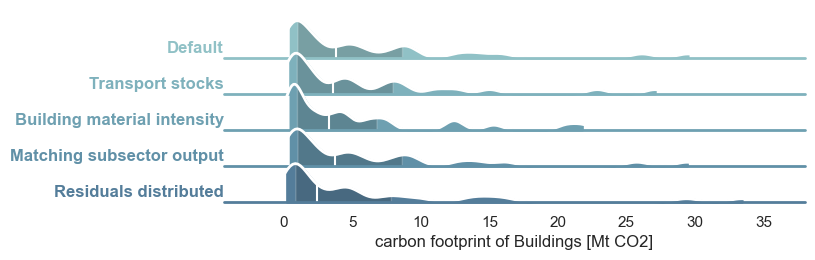

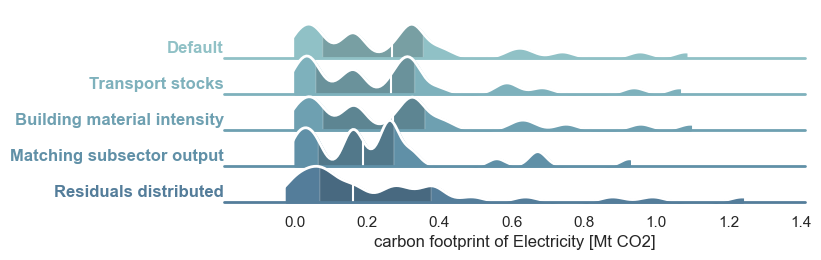

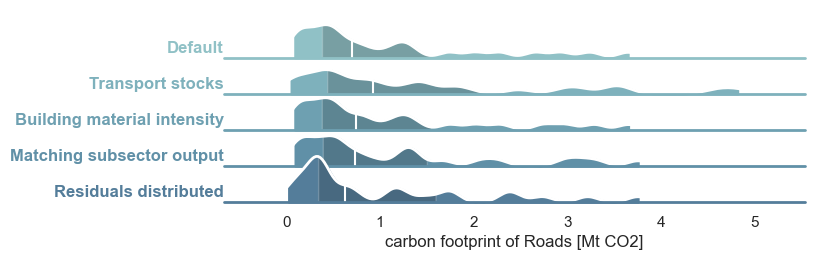

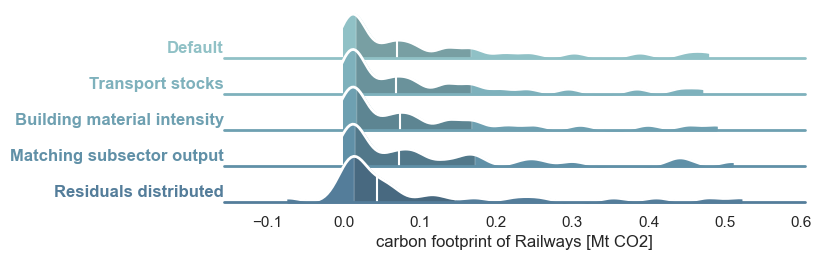

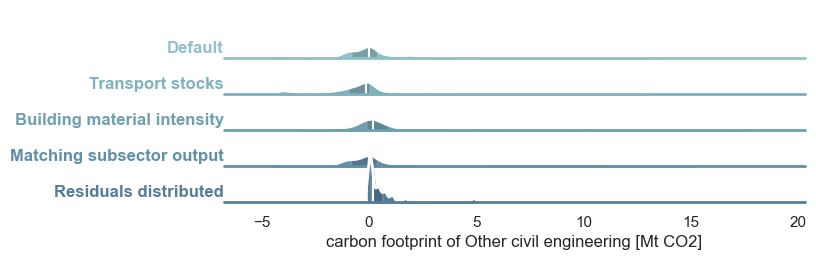

In [162]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
for i in ['Buildings', 'Electricity', 'Roads', 'Railways', 'Other civil engineering']:
      df = e_sub_eu_scenarios.stack().xs(i, level=1).reset_index().drop('region', axis=1)
      df.columns = ['g', 'carbon footprint of '+i+' [Mt CO2]']

      # Initialize the FacetGrid object
      pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
      g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

      # Draw the densities in a few steps
      g.map(sns.kdeplot, 'carbon footprint of '+i+' [Mt CO2]',
            bw_adjust=.2, cut=0, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, 'carbon footprint of '+i+' [Mt CO2]', clip_on=False, color="w", lw=2, bw_adjust=.2)
      
      for plotname, ax in g.axes_dict.items():
            kdeline = ax.lines[0]
            #middle = df.loc[df['g']==plotname, 'carbon footprint of '+i+' [Mt CO2]'].median()
            left, middle, right = np.percentile(df.loc[df['g']==plotname, 'carbon footprint of '+i+' [Mt CO2]'], [25, 50, 75])
            xs = kdeline.get_xdata()
            ys = kdeline.get_ydata()
            #height = np.interp(mean, xs, ys)
            ax.vlines(middle, 0, np.interp(middle, xs, ys), color='white', ls='-')
            #ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
            #ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
            ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=False, facecolor='k', alpha=0.2)
      

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                        ha="right", va="center", transform=ax.transAxes)


      g.map(label, 'carbon footprint of '+i+' [Mt CO2]')

      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles('')
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)

      g.savefig('images/kdeplot_e_sub_eu_'+i+'_scenarios.svg')

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

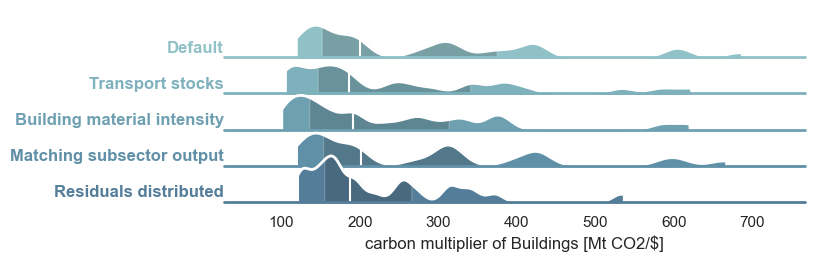

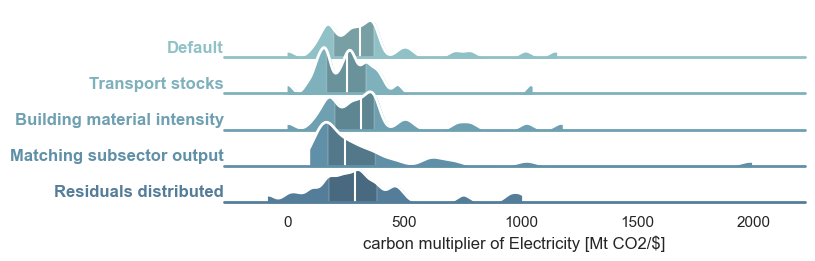

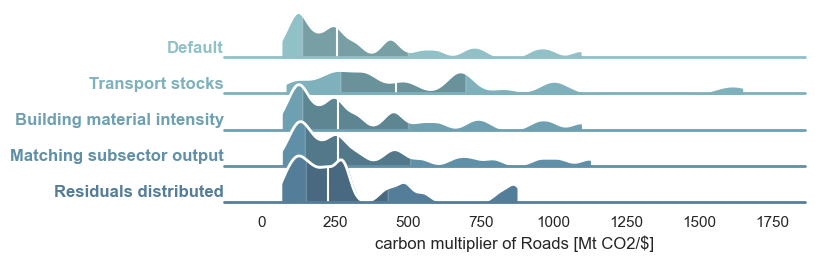

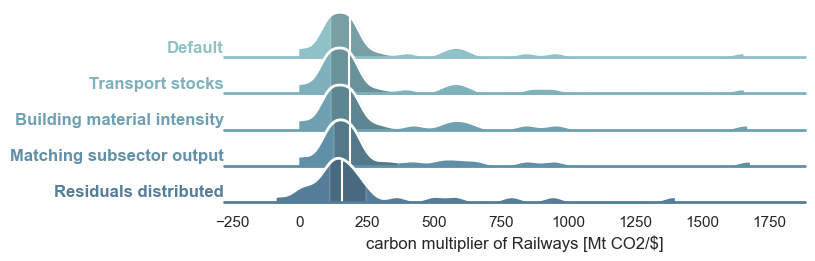

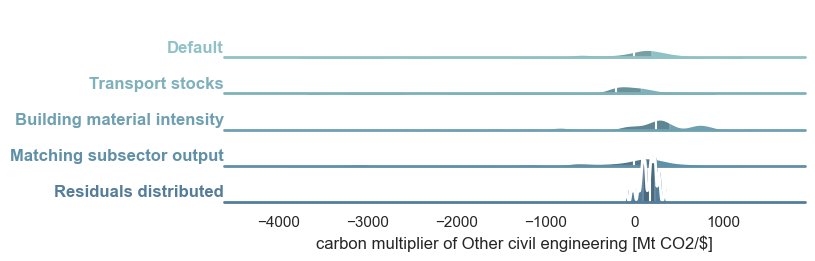

In [154]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
for i in ['Buildings', 'Electricity', 'Roads', 'Railways', 'Other civil engineering']:
      df = mult_sector_sub_scenarios.stack().xs(i, level=1).reset_index().drop('region', axis=1)
      df.columns = ['g', 'carbon multiplier of '+i+' [Mt CO2/$]']

      # Initialize the FacetGrid object
      pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
      g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

      # Draw the densities in a few steps
      g.map(sns.kdeplot, 'carbon multiplier of '+i+' [Mt CO2/$]',
            bw_adjust=.2, cut=0, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, 'carbon multiplier of '+i+' [Mt CO2/$]', clip_on=False, color="w", lw=2, bw_adjust=.2)
      
      for plotname, ax in g.axes_dict.items():
            kdeline = ax.lines[0]
            #middle = df.loc[df['g']==plotname, 'carbon footprint of '+i+' [Mt CO2]'].median()
            left, middle, right = np.percentile(df.loc[df['g']==plotname, 'carbon multiplier of '+i+' [Mt CO2/$]'], [25, 50, 75])
            xs = kdeline.get_xdata()
            ys = kdeline.get_ydata()
            #height = np.interp(mean, xs, ys)
            ax.vlines(middle, 0, np.interp(middle, xs, ys), color='white', ls='-')
            #ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
            #ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
            ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=False, facecolor='k', alpha=0.2)
      

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                        ha="right", va="center", transform=ax.transAxes)


      g.map(label, 'carbon multiplier of '+i+' [Mt CO2/$]')

      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles('')
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)

      g.savefig('images/kdeplot_mult_sector_sub_'+i+'_scenarios.svg')